In [2]:
import sys, os, glob
import warnings
import numpy as np
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt

import scipy as sp
from scipy.optimize import curve_fit
warnings.filterwarnings("ignore")
import pandas as pd
#Setting the default style of our plots.

plt.style.use('seaborn-muted')
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.autolayout'] = True
matplotlib.rcParams['figure.figsize'] = (5.5, 4)
matplotlib.rcParams['legend.fontsize'] = 'small'
matplotlib.rcParams['legend.title_fontsize'] = 'small'
matplotlib.rcParams['legend.loc'] = 'best'
plotOptions={'marker':'o', 'linestyle':'-', 'linewidth':0.5, 'alpha':0.8, 'elinewidth':2}

In [3]:
## Things defined here usually require quick access. Therefore, keep it short and don't put any random shit in it!!
month = '/Users/jackmango/Desktop/QUIRP - Work/Princeton/thompsonlab/AMO/Daily/2306'
day = '/230601'
#sys.path.append(month)
from analysis_thompsonlab_amo import *

# simulation files
# from Yb import *
# from lindblad import *

prefix = month + day
res = results(prefix)

# Run4: imaging spec

In [30]:
%matplotlib widget
data = {}
argsThresh = {}
run = 'run9'
cam = 'pvcam'

data[cam] = dataset(run + '/' + cam, prefix)
argsThresh[cam] = np.load(prefix+'\\thresholds230602_15ms.npz')
positions, thresholds, weights, rAtom = argsThresh[cam]['positions'], argsThresh[cam]['thresholds'], argsThresh[cam]['weights'], argsThresh[cam]['rAtom']
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=True)

showImageArgs = {'positions': positions, 'rAtom': rAtom, 'imagesPerSequence': 2, 'whichImage': 0, 'binaryPics': False,
                 'circle': False, 'transpose': True, 'averaged': True, 'ROI': (0, 0, 4000, 1000), 
                 'cameraType': 'pvcam', 'plotOptions': {'vmin': 0, 'vmax': 30, 'cmap': 'cubehelix'}}
img = showPositionsExperiment(data[cam].files[-1], showImageArgs)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jackmango/Desktop/QUIRP - Work/Princeton/thompsonlab/AMO/Daily/2306/230601\\thresholds230602_15ms.npz'

In [14]:
%matplotlib widget
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].addParams(run, prefix)

mParams = ['imagingDetuning0_MHz']
includefn = lambda f: True # if f.params['iterator'] <50  else False
fx = 1
center = 0

d = measurement(data[cam], mParams, includefn=includefn)
cameraCountsArgs = {'positions':positions_10x10, 'rAtom':2, 'imagesPerSequence': 1, 'whichImage': 0,
                    'cameraType': 'pvcam', 'bgExcludeRegion': None, 'averageOverPositions': True}
y, yerr = d.measure(cameraCounts, fn_args=cameraCountsArgs)
x = (d.x_raw - center) * fx


fn = rabiTheoryPos
# fn = lambda x, a, f, phi, c: a * np.cos(2 * np.pi * f * x - phi) + c
res.addResult(run, mParams, x, y, yerr)
# fit, errs = res.fitResult(run, 'RF spectrum; Fn: RabiTheoryPos', fn, x, y, yerr=np.clip(yerr, a_min=0.01, a_max=np.inf), fit_options={'p0': [5.7, 0.35, 1.5, 1], 'maxfev': 30000})
plt.figure()
res.plot([run], plotOptions={'linestyle':'--', 'marker':'o'})
# res.plotFittedCurve(fn, x, fit)
plt.legend(title='OP detuning [V]')
plt.gca().set_prop_cycle(None)
plt.show()




KeyError: 'pvcam'

# Run5: cw imaging; imagingDetuning = -0.6

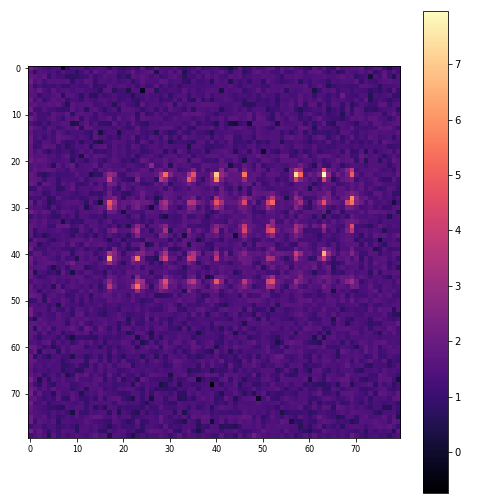

In [368]:
%matplotlib widget
run = 'run5'
cam = 'pvcam'
argsThresh = {}
data = dataset(run + '\\' + cam, prefix)

showImageArgs = {'positions':positions, 'rAtom':2, 'circle':False,'transpose':True,
                 'cameraType': 'pvcam', 'plotOptions':{'cmap':'magma'}}

img = showPositionsCWImage(data.files[-1], showImageArgs)

In [369]:
%matplotlib inline
data.addDir(run + '\\' + cam, prefix)
mParams = ['all']
includefn = lambda f: True # if f.params['imagingDetuning0_MHz']== -0.6 else False
d = measurement(data, mParams, includefn=includefn)

cwImageArgs = {'positions':positions_10x10, 'nLoops':20, 'threshold':20, 'rAtom':2, 'cameraType': 'pvcam',
               'bgExcludeRegion':[[10,5],[73,75]], 'averageOverPositions': True}
y, yerr = d.measure(cameraCountsContinuousImageBackgroundConditioned, cwImageArgs)
x = (d.xVals_unique)
dt = 20e-3

fitRes = {'lifetime [s]':[],'lifetimeErr [s]':[], 'initCounts': [], 'initCountsErr': []}
plt.figure()
for i in range(len(y)):
    times = np.arange(0, (len(y[i])), 1) * dt
    fit, cov = curve_fit(expon_decay_no_offset, times[1:], y[i][1:], p0 = [50,1])
    line, = plt.plot(times, expon_decay_no_offset(times, *fit))
    plt.errorbar(times, y[i], yerr=yerr[i], color=line.get_color(), marker='.', alpha=0.4, linestyle='', label = x[i])
    fitRes['lifetime [s]'].append(fit[1])
    fitRes['lifetimeErr [s]'].append(cov[1,1]**0.5)
    fitRes['initCounts'].append(fit[0])
    fitRes['initCountsErr'].append(cov[0, 0]**0.5)
    
plt.xlabel('Imaging time [s]')
plt.ylabel('Counts')
plt.title('fitted lifetime: {:.2f} $\pm$ {:.2f}s'.format(fit[1],cov[1,1]**0.5))
plt.legend()
# plt.ylim(0, 100)
plt.show()

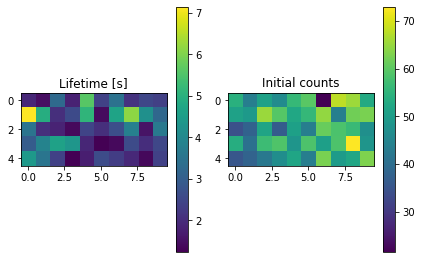

In [370]:
%matplotlib inline
data.addDir(run + '\\' + cam, prefix)
mParams = ['all']
includefn = lambda f: True #if f.params['tweezerPowerImaging_mW']== 1600 else False
d = measurement(data, mParams, includefn=includefn)

cwImageArgs = {'positions':positions, 'nLoops':20, 'threshold':20, 'rAtom':2, 'cameraType': 'pvcam',
               'bgExcludeRegion':[[10,5],[73,75]], 'averageOverPositions': False}
y, yerr = d.measure(cameraCountsContinuousImageBackgroundConditioned, cwImageArgs)
x = (d.xVals_unique)
dt = 20e-3

y = y[0]
yerr = yerr[0]

fitRes = {'lifetime [s]':[],'lifetimeErr [s]':[], 'initCounts': [], 'initCountsErr': []}
plt.figure()
for i in range(len(y)):
    times = np.arange(0, len(y[i]), 1) * dt
    fit,cov = curve_fit(expon_decay_no_offset, times[1:], y[i][1:], p0 = [50,1])
    # line, = plt.plot(times, expon_decay_no_offset(times, *fit))
    plt.errorbar(times, y[i], yerr=yerr[i], marker='.', alpha=0.4, linestyle='', 
                 label='Tweezer #{:.0f}'.format(i))
    fitRes['lifetime [s]'].append(fit[1])
    fitRes['lifetimeErr [s]'].append(cov[1,1]**0.5)
    fitRes['initCounts'].append(fit[0])
    fitRes['initCountsErr'].append(cov[0, 0]**0.5)
plt.xlabel('Imaging time [s]')
plt.ylabel('Counts')
# plt.ylim(0, 70)
# plt.legend(ncol=10)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(6, 6/1.62))
# ax[0].bar(np.arange(len(y)), fitRes['lifetime [s]'], yerr=fitRes['lifetimeErr [s]'])
plt.sca(ax[0])
plt.title('Lifetime [s]')
plt.imshow( np.array(fitRes['lifetime [s]']).reshape((-1,10)))
plt.colorbar()
plt.sca(ax[1])
plt.title('Initial counts')
# ax[1].set_xlabel('Tweezers')
plt.imshow( np.array(fitRes['initCounts']).reshape((-1,10)))
plt.colorbar()
plt.show()

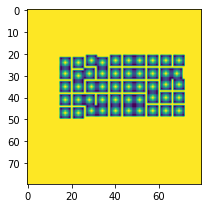

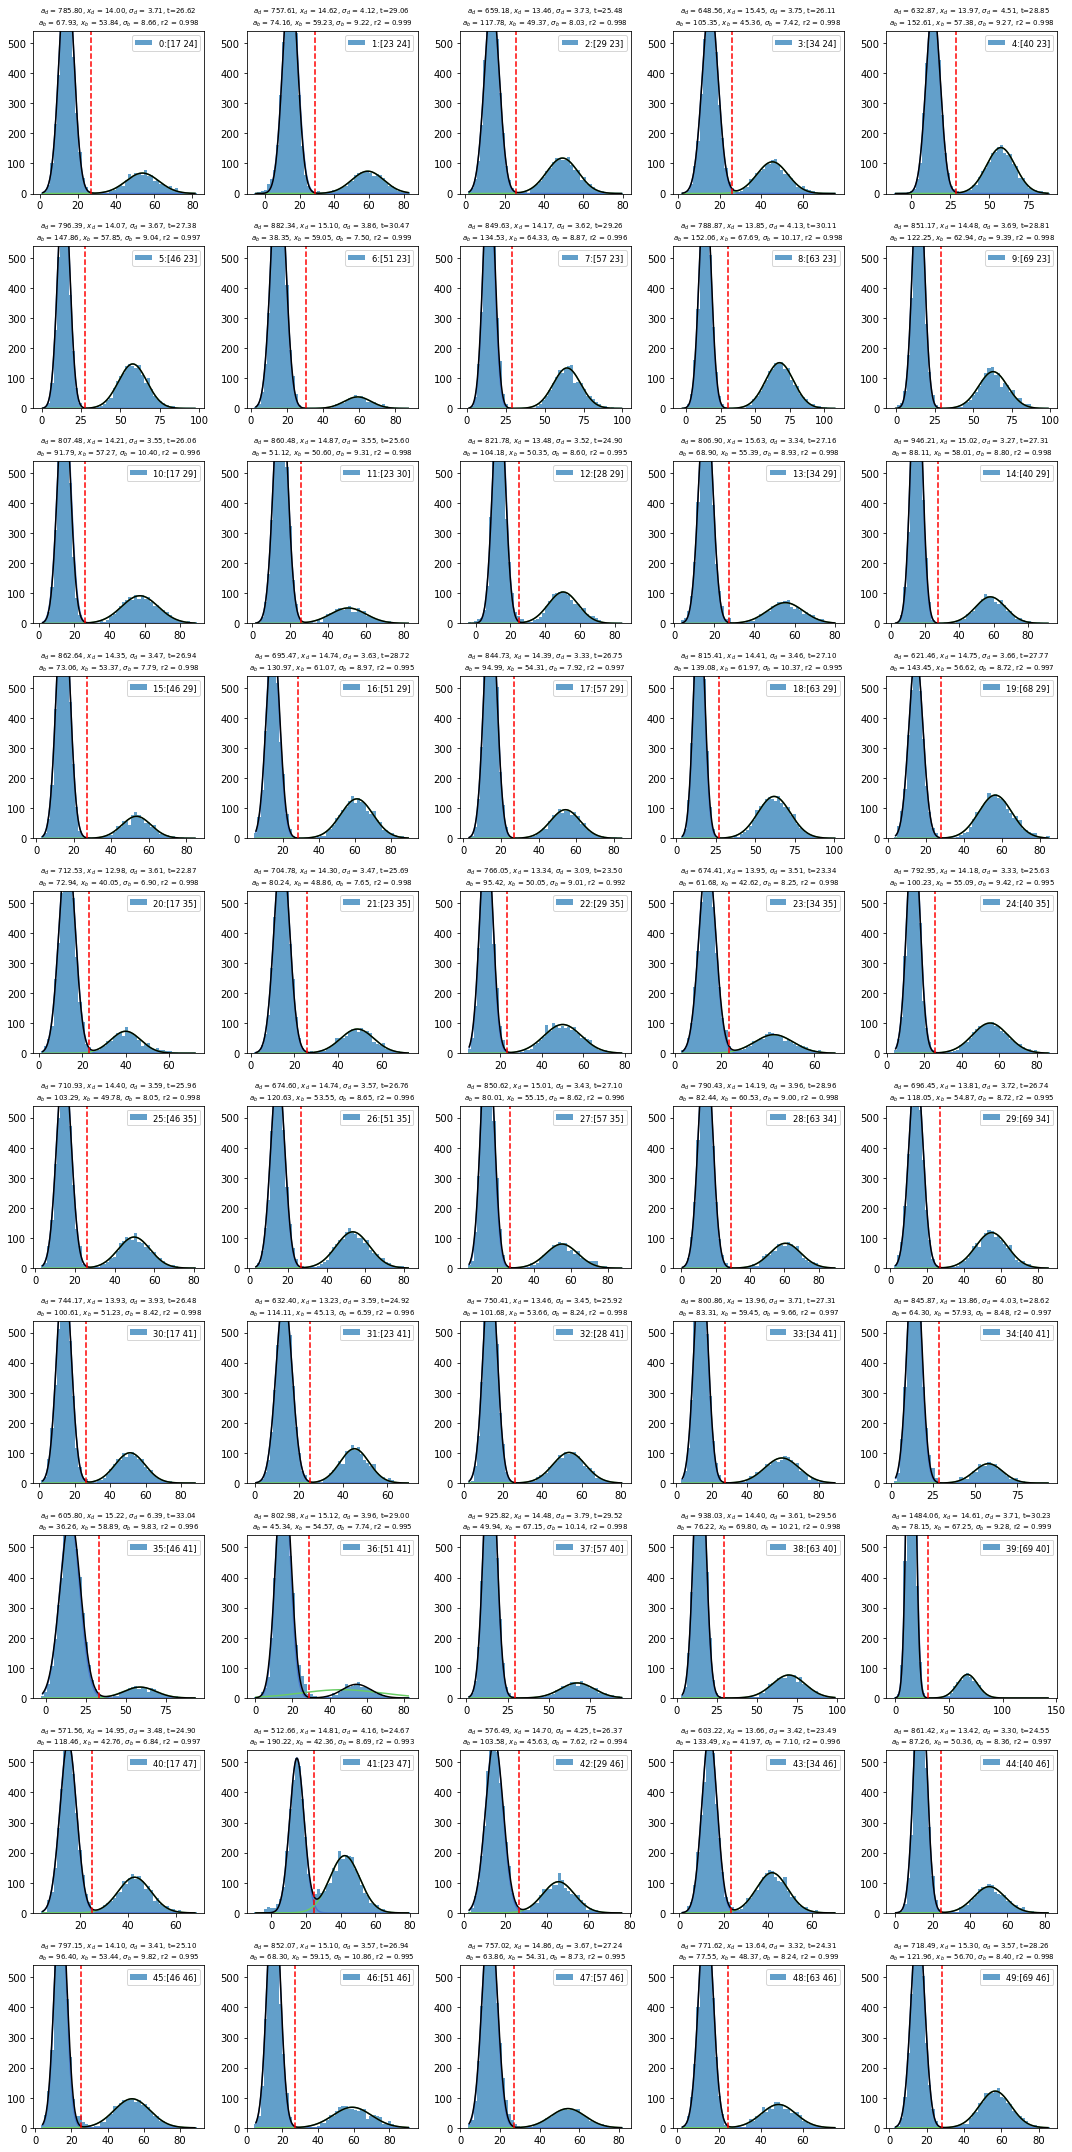

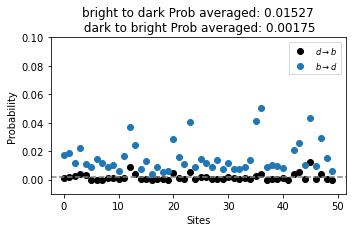

In [371]:
%matplotlib inline
data.addDir(run + '\\' + cam, prefix)
includefn = lambda f: True # if f.params['imagingDetuning0_MHz'] == -0.55 else False
dhist = measurement(data, ['all'], includefn=includefn)

nTweezers = 100
histy = weighted_histogram_556(dhist.files, positions=positions, rAtom=2, exclude1st = True, nLoops = 20)
histy.calculateWeights(bgExcludeRegion = [[10,5],[73,75]])

fitParams = [5 for _ in range(nTweezers)]
histy.applyWeights(weights=True, fitParams=fitParams)

histy.thresholds[41]= 10000

probs = histy.fidelityAnalysis(plot=True)

In [36]:
probs

{'darkToBright': array([0.0011241 , 0.00203943, 0.00257599, 0.00395648, 0.00306407,
        0.        , 0.        , 0.        , 0.00082102, 0.00076239,
        0.00074313, 0.00107666, 0.0090531 , 0.00365297, 0.00023326,
        0.00022212, 0.        , 0.00070956, 0.00027988, 0.        ,
        0.00470852, 0.00139762, 0.00075662, 0.00520715, 0.00050505,
        0.00148038, 0.00213447, 0.00069396, 0.0004603 , 0.00051935,
        0.00168188, 0.00099502, 0.00073983, 0.00094429, 0.00043271,
        0.00244998, 0.00393619, 0.        , 0.00045662, 0.00021057,
        0.00131303, 0.        , 0.00393895, 0.00542594, 0.0004686 ,
        0.01203309, 0.00023111, 0.00357462, 0.00046458, 0.        ]),
 'brightToDark': array([0.01754386, 0.01900739, 0.01150203, 0.02203647, 0.01073446,
        0.00897129, 0.01452785, 0.0114094 , 0.0087925 , 0.01052632,
        0.00604686, 0.01675978, 0.03692066, 0.0244898 , 0.00745573,
        0.01282051, 0.00416171, 0.00883392, 0.00559597, 0.0063762 ,
        0.0288

In [37]:
plt.figure()
plt.imshow(probs['brightToDark'].reshape((-1,10)))
plt.colorbar()
plt.show()

np.savez(r'I:/thompsonlab/AMO/Control programs/calibrationData/556ImagingThresholds/thresholds230522_15ms.npz', cameraType='pvcam', rAtom=2, thresholds=histy.thresholds, weights=histy.mask, positions=positions2d_487nm_10x10)
np.savez(prefix + r'/thresholds230522_15ms.npz', cameraType='pvcam', rAtom=2, thresholds=histy.thresholds, weights=histy.mask, positions=positions2d_487nm_10x10)

histy.thresholds

# Run8: cw imaging; imagingDetuning = -0.57

Imaging HWP angle = 136 deg

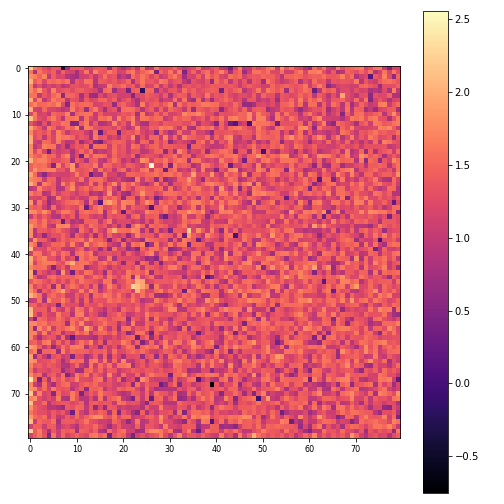

In [38]:
%matplotlib widget
run = 'run8'
cam = 'pvcam'
argsThresh = {}
data = dataset(run + '\\' + cam, prefix)

showImageArgs = {'positions':positions, 'rAtom':2, 'circle':False,'transpose':True,
                 'cameraType': 'pvcam', 'plotOptions':{'cmap':'magma'}}

img = showPositionsCWImage(data.files[-1], showImageArgs)

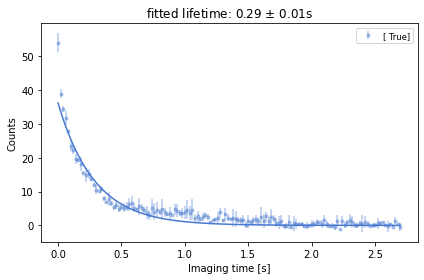

In [39]:
%matplotlib inline
data.addDir(run + '\\' + cam, prefix)
mParams = ['all']
includefn = lambda f: True # if f.params['imagingDetuning0_MHz']== -0.6 else False
d = measurement(data, mParams, includefn=includefn)

cwImageArgs = {'positions':positions_10x10, 'nLoops':20, 'threshold':20, 'rAtom':2, 'cameraType': 'pvcam',
               'bgExcludeRegion':[[10,5],[73,75]], 'averageOverPositions': True}
y, yerr = d.measure(cameraCountsContinuousImageBackgroundConditioned, cwImageArgs)
x = (d.xVals_unique)
dt = 20e-3

fitRes = {'lifetime [s]':[],'lifetimeErr [s]':[], 'initCounts': [], 'initCountsErr': []}
plt.figure()
for i in range(len(y)):
    times = np.arange(0, (len(y[i])), 1) * dt
    fit, cov = curve_fit(expon_decay_no_offset, times[1:], y[i][1:], p0 = [50,1])
    line, = plt.plot(times, expon_decay_no_offset(times, *fit))
    plt.errorbar(times, y[i], yerr=yerr[i], color=line.get_color(), marker='.', alpha=0.4, linestyle='', label = x[i])
    fitRes['lifetime [s]'].append(fit[1])
    fitRes['lifetimeErr [s]'].append(cov[1,1]**0.5)
    fitRes['initCounts'].append(fit[0])
    fitRes['initCountsErr'].append(cov[0, 0]**0.5)
    
plt.xlabel('Imaging time [s]')
plt.ylabel('Counts')
plt.title('fitted lifetime: {:.2f} $\pm$ {:.2f}s'.format(fit[1],cov[1,1]**0.5))
plt.legend()
# plt.ylim(0, 100)
plt.show()

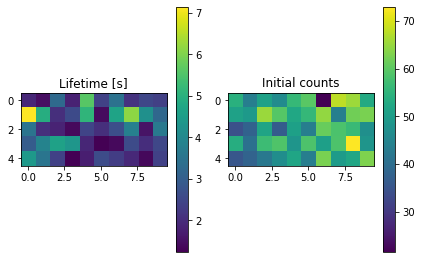

In [33]:
%matplotlib inline
data.addDir(run + '\\' + cam, prefix)
mParams = ['all']
includefn = lambda f: True #if f.params['tweezerPowerImaging_mW']== 1600 else False
d = measurement(data, mParams, includefn=includefn)

cwImageArgs = {'positions':positions, 'nLoops':20, 'threshold':20, 'rAtom':2, 'cameraType': 'pvcam',
               'bgExcludeRegion':[[10,5],[73,75]], 'averageOverPositions': False}
y, yerr = d.measure(cameraCountsContinuousImageBackgroundConditioned, cwImageArgs)
x = (d.xVals_unique)
dt = 20e-3

y = y[0]
yerr = yerr[0]

fitRes = {'lifetime [s]':[],'lifetimeErr [s]':[], 'initCounts': [], 'initCountsErr': []}
plt.figure()
for i in range(len(y)):
    times = np.arange(0, len(y[i]), 1) * dt
    fit,cov = curve_fit(expon_decay_no_offset, times[1:], y[i][1:], p0 = [50,1])
    # line, = plt.plot(times, expon_decay_no_offset(times, *fit))
    plt.errorbar(times, y[i], yerr=yerr[i], marker='.', alpha=0.4, linestyle='', 
                 label='Tweezer #{:.0f}'.format(i))
    fitRes['lifetime [s]'].append(fit[1])
    fitRes['lifetimeErr [s]'].append(cov[1,1]**0.5)
    fitRes['initCounts'].append(fit[0])
    fitRes['initCountsErr'].append(cov[0, 0]**0.5)
plt.xlabel('Imaging time [s]')
plt.ylabel('Counts')
# plt.ylim(0, 70)
# plt.legend(ncol=10)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(6, 6/1.62))
# ax[0].bar(np.arange(len(y)), fitRes['lifetime [s]'], yerr=fitRes['lifetimeErr [s]'])
plt.sca(ax[0])
plt.title('Lifetime [s]')
plt.imshow( np.array(fitRes['lifetime [s]']).reshape((-1,10)))
plt.colorbar()
plt.sca(ax[1])
plt.title('Initial counts')
# ax[1].set_xlabel('Tweezers')
plt.imshow( np.array(fitRes['initCounts']).reshape((-1,10)))
plt.colorbar()
plt.show()

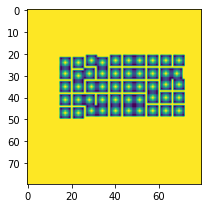

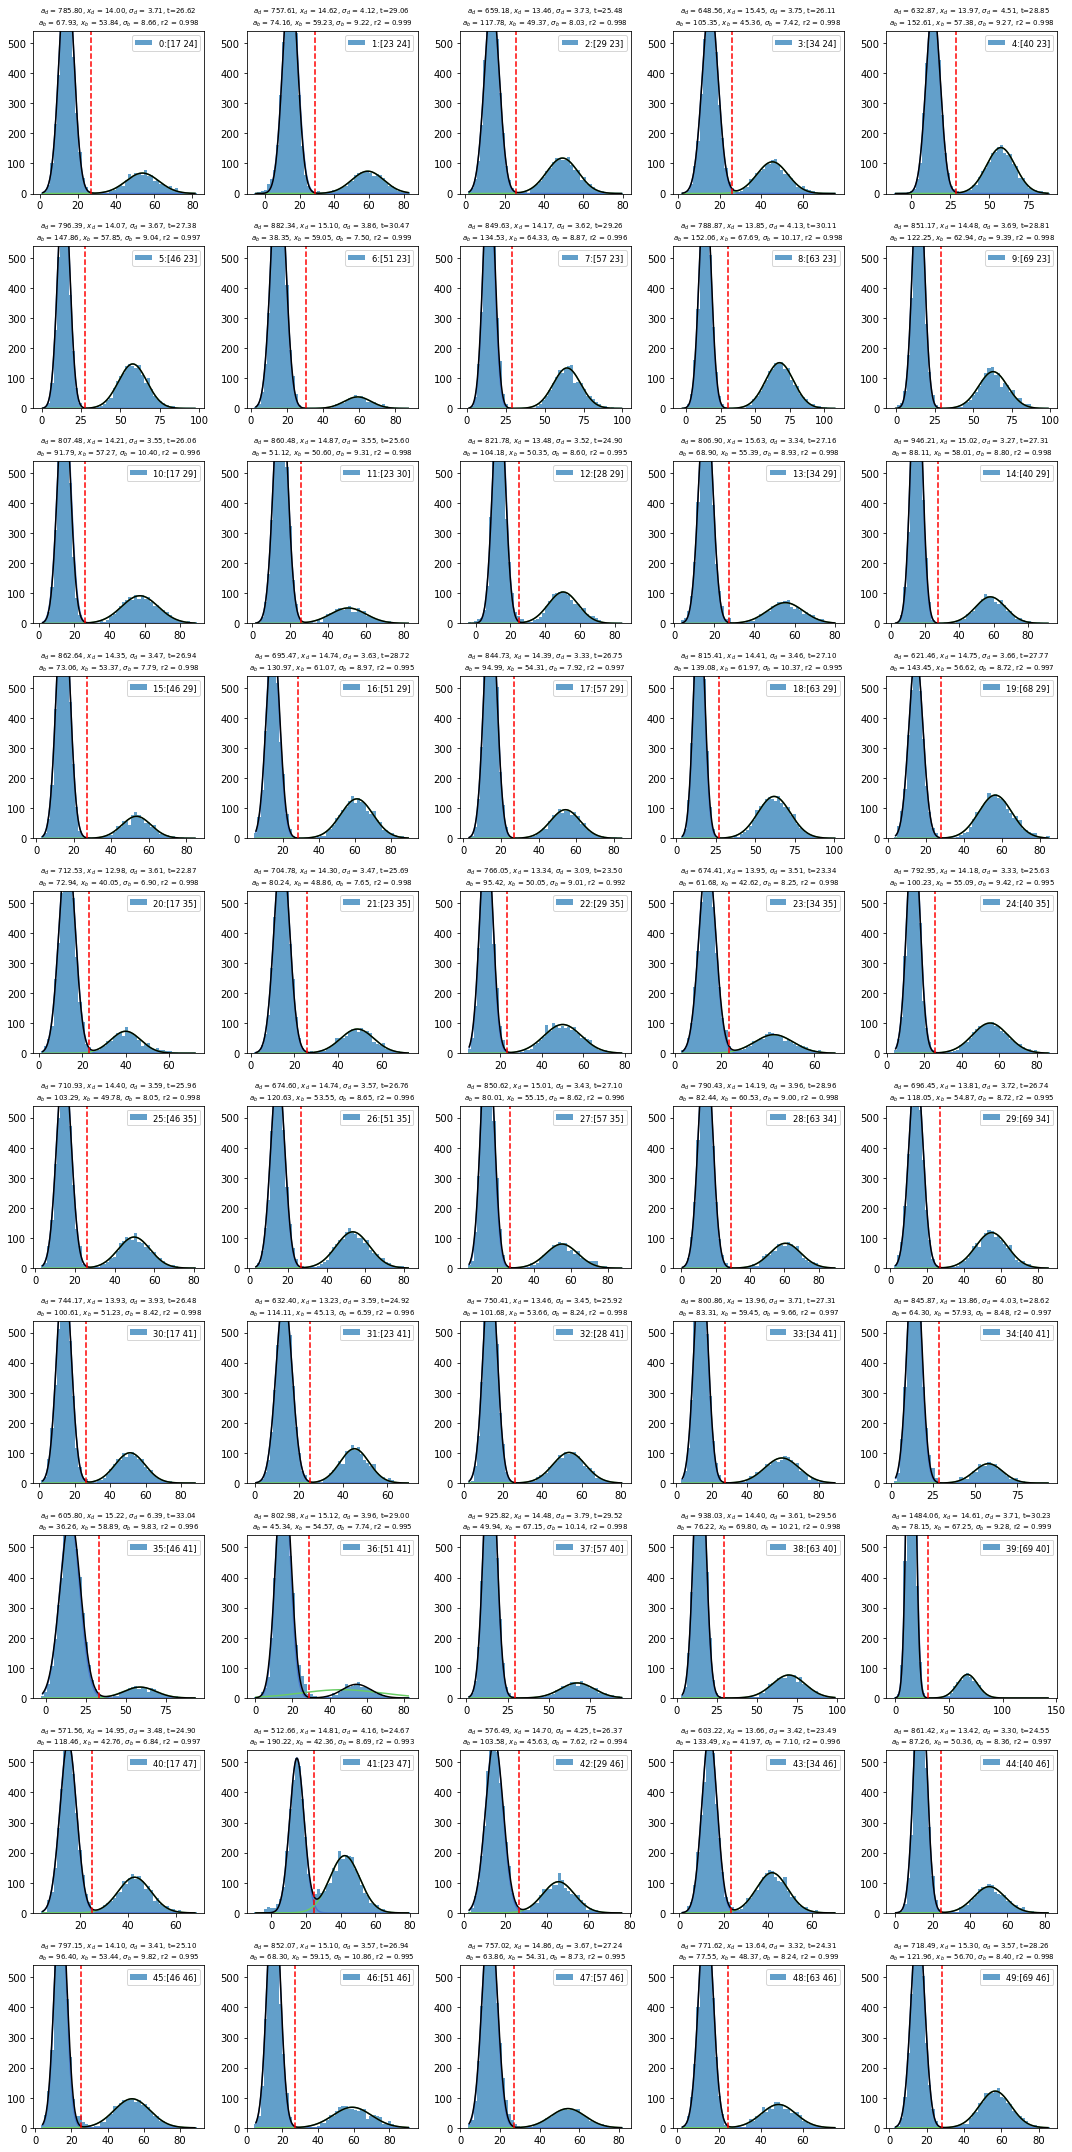

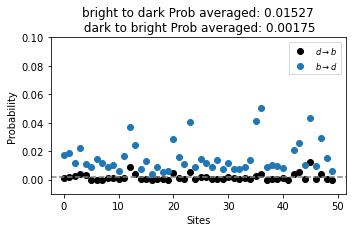

In [26]:
%matplotlib inline
data.addDir(run + '\\' + cam, prefix)
includefn = lambda f: True # if f.params['imagingDetuning0_MHz'] == -0.55 else False
dhist = measurement(data, ['all'], includefn=includefn)

nTweezers = 100
histy = weighted_histogram_556(dhist.files, positions=positions, rAtom=2, exclude1st = True, nLoops = 20)
histy.calculateWeights(bgExcludeRegion = [[10,5],[73,75]])

fitParams = [5 for _ in range(nTweezers)]
histy.applyWeights(weights=True, fitParams=fitParams)

histy.thresholds[41]= 10000

probs = histy.fidelityAnalysis(plot=True)

np.savez(r'I:/thompsonlab/AMO/Control programs/calibrationData/556ImagingThresholds/thresholds230522_15ms.npz', cameraType='pvcam', rAtom=2, thresholds=histy.thresholds, weights=histy.mask, positions=positions2d_487nm_10x10)
np.savez(prefix + r'/thresholds230522_15ms.npz', cameraType='pvcam', rAtom=2, thresholds=histy.thresholds, weights=histy.mask, positions=positions2d_487nm_10x10)

histy.thresholds

# Run9: cw imaging; imagingDetuning = -0.6; imagingPower = 0.04

Imaging HWP angle = 158 deg

In [6]:
%matplotlib widget
run = 'run9'
cam = 'pvcam'
argsThresh = {}
data = dataset(run + '/' + cam, prefix)

#showImageArgs = {'positions':positions, 'rAtom':2, 'circle':False,'transpose':True,
                 #'cameraType': 'pvcam', 'plotOptions':{'cmap':'magma'}}

#img = showPositionsCWImage(data.files[-1], showImageArgs)

In [5]:
%matplotlib inline
data.addDir(run + '/' + cam, prefix)
mParams = ['all']
includefn = lambda f: True # if f.params['imagingDetuning0_MHz']== -0.6 else False
d = measurement(data, mParams, includefn=includefn)

cwImageArgs = {'positions':positions_10x10, 'nLoops':20, 'threshold':20, 'rAtom':2, 'cameraType': 'pvcam',
               'bgExcludeRegion':[[10,5],[73,75]], 'averageOverPositions': True}
y, yerr = d.measure(cameraCountsContinuousImageBackgroundConditioned, cwImageArgs)
x = (d.xVals_unique)
dt = 20e-3

fitRes = {'lifetime [s]':[],'lifetimeErr [s]':[], 'initCounts': [], 'initCountsErr': []}
plt.figure()
for i in range(len(y)):
    times = np.arange(0, (len(y[i])), 1) * dt
    fit, cov = curve_fit(expon_decay_no_offset, times[1:], y[i][1:], p0 = [50,1])
    line, = plt.plot(times, expon_decay_no_offset(times, *fit))
    plt.errorbar(times, y[i], yerr=yerr[i], color=line.get_color(), marker='.', alpha=0.4, linestyle='', label = x[i])
    fitRes['lifetime [s]'].append(fit[1])
    fitRes['lifetimeErr [s]'].append(cov[1,1]**0.5)
    fitRes['initCounts'].append(fit[0])
    fitRes['initCountsErr'].append(cov[0, 0]**0.5)
    
plt.xlabel('Imaging time [s]')
plt.ylabel('Counts')
plt.title('fitted lifetime: {:.2f} $\pm$ {:.2f}s'.format(fit[1],cov[1,1]**0.5))
plt.legend()
# plt.ylim(0, 100)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jackmango/Desktop/QUIRP - Work/Princeton/thompsonlab/AMO/Daily/2306/230601/run9\\pvcam'

In [42]:
%matplotlib inline
data.addDir(run + '\\' + cam, prefix)
mParams = ['all']
includefn = lambda f: True #if f.params['tweezerPowerImaging_mW']== 1600 else False
d = measurement(data, mParams, includefn=includefn)

cwImageArgs = {'positions':positions, 'nLoops':20, 'threshold':20, 'rAtom':2, 'cameraType': 'pvcam',
               'bgExcludeRegion':[[10,5],[73,75]], 'averageOverPositions': False}
y, yerr = d.measure(cameraCountsContinuousImageBackgroundConditioned, cwImageArgs)
x = (d.xVals_unique)
dt = 20e-3

y = y[0]
yerr = yerr[0]

fitRes = {'lifetime [s]':[],'lifetimeErr [s]':[], 'initCounts': [], 'initCountsErr': []}
plt.figure()
for i in range(len(y)):
    times = np.arange(0, len(y[i]), 1) * dt
    fit,cov = curve_fit(expon_decay_no_offset, times[1:], y[i][1:], p0 = [50,1])
    # line, = plt.plot(times, expon_decay_no_offset(times, *fit))
    plt.errorbar(times, y[i], yerr=yerr[i], marker='.', alpha=0.4, linestyle='', 
                 label='Tweezer #{:.0f}'.format(i))
    fitRes['lifetime [s]'].append(fit[1])
    fitRes['lifetimeErr [s]'].append(cov[1,1]**0.5)
    fitRes['initCounts'].append(fit[0])
    fitRes['initCountsErr'].append(cov[0, 0]**0.5)
plt.xlabel('Imaging time [s]')
plt.ylabel('Counts')
# plt.ylim(0, 70)
# plt.legend(ncol=10)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(6, 6/1.62))
# ax[0].bar(np.arange(len(y)), fitRes['lifetime [s]'], yerr=fitRes['lifetimeErr [s]'])
plt.sca(ax[0])
plt.title('Lifetime [s]')
plt.imshow( np.array(fitRes['lifetime [s]']).reshape((-1,10)))
plt.colorbar()
plt.sca(ax[1])
plt.title('Initial counts')
# ax[1].set_xlabel('Tweezers')
plt.imshow( np.array(fitRes['initCounts']).reshape((-1,10)))
plt.colorbar()
plt.show()

ValueError: array must not contain infs or NaNs

In [1]:
%matplotlib inline
data.addDir(run + '/' + cam, prefix)
includefn = lambda f: True # if f.params['imagingDetuning0_MHz'] == -0.55 else False
dhist = measurement(data, ['all'], includefn=includefn)

nTweezers = 100
print(dhist.files)
histy = weighted_histogram_556(dhist.files, nTweezers=100, positions=None, rAtom=2, exclude1st = True, nLoops = 20)
#histy.calculateWeights(bgExcludeRegion = [[10,5],[73,75]])

#fitParams = [5 for _ in range(nTweezers)]
#histy.applyWeights(weights=True, fitParams=fitParams)

#histy.thresholds[41]= 10000

probs = histy.fidelityAnalysis(plot=True)

NameError: name 'data' is not defined

np.savez(r'I:/thompsonlab/AMO/Control programs/calibrationData/556ImagingThresholds/thresholds230522_15ms.npz', cameraType='pvcam', rAtom=2, thresholds=histy.thresholds, weights=histy.mask, positions=positions2d_487nm_10x10)
np.savez(prefix + r'/thresholds230522_15ms.npz', cameraType='pvcam', rAtom=2, thresholds=histy.thresholds, weights=histy.mask, positions=positions2d_487nm_10x10)

histy.thresholds

# Run11: cw imaging; imagingDetuning = -0.6; imagingPower = 0.015

Imaging HWP angle = 158 deg

In [94]:
%matplotlib widget
run = 'run11'
cam = 'pvcam'
argsThresh = {}
data = dataset(run + '\\' + cam, prefix)

showImageArgs = {'positions':positions, 'rAtom':2, 'circle':False,'transpose':True,
                 'cameraType': 'pvcam', 'plotOptions':{'cmap':'magma'}}

img = showPositionsCWImage(data.files[-1], showImageArgs)

In [95]:
%matplotlib inline
data.addDir(run + '\\' + cam, prefix)
mParams = ['all']
includefn = lambda f: True # if f.params['imagingDetuning0_MHz']== -0.6 else False
d = measurement(data, mParams, includefn=includefn)

cwImageArgs = {'positions':positions_10x10, 'nLoops':20, 'threshold':20, 'rAtom':2, 'cameraType': 'pvcam',
               'bgExcludeRegion':[[10,5],[73,75]], 'averageOverPositions': True}
y, yerr = d.measure(cameraCountsContinuousImageBackgroundConditioned, cwImageArgs)
x = (d.xVals_unique)
dt = 20e-3

fitRes = {'lifetime [s]':[],'lifetimeErr [s]':[], 'initCounts': [], 'initCountsErr': []}
plt.figure()
for i in range(len(y)):
    times = np.arange(0, (len(y[i])), 1) * dt
    fit, cov = curve_fit(expon_decay_no_offset, times[1:], y[i][1:], p0 = [50,1])
    line, = plt.plot(times, expon_decay_no_offset(times, *fit))
    plt.errorbar(times, y[i], yerr=yerr[i], color=line.get_color(), marker='.', alpha=0.4, linestyle='', label = x[i])
    fitRes['lifetime [s]'].append(fit[1])
    fitRes['lifetimeErr [s]'].append(cov[1,1]**0.5)
    fitRes['initCounts'].append(fit[0])
    fitRes['initCountsErr'].append(cov[0, 0]**0.5)
    
plt.xlabel('Imaging time [s]')
plt.ylabel('Counts')
plt.title('fitted lifetime: {:.2f} $\pm$ {:.2f}s'.format(fit[1],cov[1,1]**0.5))
plt.legend()
# plt.ylim(0, 100)
plt.show()

In [96]:
%matplotlib inline
data.addDir(run + '\\' + cam, prefix)
mParams = ['all']
includefn = lambda f: True #if f.params['tweezerPowerImaging_mW']== 1600 else False
d = measurement(data, mParams, includefn=includefn)

cwImageArgs = {'positions':positions, 'nLoops':20, 'threshold':20, 'rAtom':2, 'cameraType': 'pvcam',
               'bgExcludeRegion':[[10,5],[73,75]], 'averageOverPositions': False}
y, yerr = d.measure(cameraCountsContinuousImageBackgroundConditioned, cwImageArgs)
x = (d.xVals_unique)
dt = 20e-3

y = y[0]
yerr = yerr[0]

fitRes = {'lifetime [s]':[],'lifetimeErr [s]':[], 'initCounts': [], 'initCountsErr': []}
plt.figure()
for i in range(len(y)):
    times = np.arange(0, len(y[i]), 1) * dt
    fit,cov = curve_fit(expon_decay_no_offset, times[1:], y[i][1:], p0 = [50,1])
    # line, = plt.plot(times, expon_decay_no_offset(times, *fit))
    plt.errorbar(times, y[i], yerr=yerr[i], marker='.', alpha=0.4, linestyle='', 
                 label='Tweezer #{:.0f}'.format(i))
    fitRes['lifetime [s]'].append(fit[1])
    fitRes['lifetimeErr [s]'].append(cov[1,1]**0.5)
    fitRes['initCounts'].append(fit[0])
    fitRes['initCountsErr'].append(cov[0, 0]**0.5)
plt.xlabel('Imaging time [s]')
plt.ylabel('Counts')
# plt.ylim(0, 70)
# plt.legend(ncol=10)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(6, 6/1.62))
# ax[0].bar(np.arange(len(y)), fitRes['lifetime [s]'], yerr=fitRes['lifetimeErr [s]'])
plt.sca(ax[0])
plt.title('Lifetime [s]')
plt.imshow( np.array(fitRes['lifetime [s]']).reshape((-1,10)))
plt.colorbar()
plt.sca(ax[1])
plt.title('Initial counts')
# ax[1].set_xlabel('Tweezers')
plt.imshow( np.array(fitRes['initCounts']).reshape((-1,10)))
plt.colorbar()
plt.show()

ValueError: array must not contain infs or NaNs

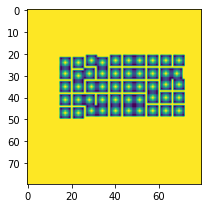

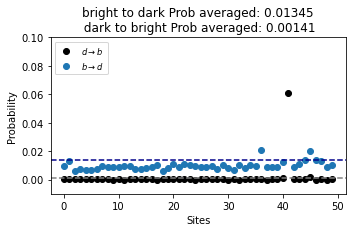

In [97]:
%matplotlib inline
data.addDir(run + '\\' + cam, prefix)
includefn = lambda f: True # if f.params['imagingDetuning0_MHz'] == -0.55 else False
dhist = measurement(data, ['all'], includefn=includefn)

nTweezers = 100
histy = weighted_histogram_556(dhist.files, positions=positions, rAtom=2, exclude1st = True, nLoops = 20)
histy.calculateWeights(bgExcludeRegion = [[10,5],[73,75]])

fitParams = [5 for _ in range(nTweezers)]
histy.applyWeights(weights=True, fitParams=fitParams)

# histy.thresholds[41]= 10000
histy.thresholds[12]= 30
histy.thresholds += 2

probs = histy.fidelityAnalysis(plot=True)

In [98]:
plt.figure()
plt.imshow(probs['brightToDark'].reshape((-1,10)))
plt.colorbar()
plt.show()

In [99]:
# np.savez(r'I:/thompsonlab/AMO/Control programs/calibrationData/556ImagingThresholds/thresholds230522_15ms.npz', cameraType='pvcam', rAtom=2, thresholds=histy.thresholds, weights=histy.mask, positions=positions2d_487nm_10x10)
np.savez(prefix + r'/thresholds230602_15ms.npz', cameraType='pvcam', rAtom=2, thresholds=histy.thresholds, weights=histy.mask, positions=positions)

histy.thresholds

array([31.00392645, 32.93034425, 29.19235116, 29.87694888, 34.06297477,
       31.25546044, 34.38259783, 33.24684604, 34.51158669, 32.62539654,
       31.48094677, 30.50353109, 32.        , 31.16060848, 31.98950712,
       30.53172233, 33.33155026, 31.12699749, 32.41003144, 31.52803167,
       26.71916248, 29.84377618, 27.43539736, 27.26576438, 29.64423925,
       30.13934134, 31.38033763, 31.66220137, 32.18501248, 30.83931015,
       30.55756558, 28.70910855, 29.62724753, 31.92207484, 33.76093241,
       38.92797083, 34.39008742, 35.03389492, 34.41759391, 33.99583805,
       27.65091961, 25.07959367, 30.36327134, 27.29663977, 28.38754252,
       29.91642449, 32.54529812, 30.77582961, 27.58133343, 31.42882364])

# Run13: pulsing trap, modulate time 100 ms, duty cycle = 50%; 360mW averaged trap power

peak voltage on scope: 564 mV; bottom:76 mV; avg = 320 mV

Checking and converting all pictures into binary:   0%|          | 0/25 [00:00<?, ?it/s]

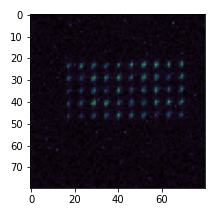

In [294]:
%matplotlib widget
data = {}
argsThresh = {}
run = 'run13'
cam = 'pvcam'

data[cam] = dataset(run + '\\' + cam, prefix)
argsThresh[cam] = np.load(prefix+'\\thresholds230609_15ms.npz')
positions, thresholds, weights, rAtom = argsThresh[cam]['positions'], argsThresh[cam]['thresholds'], argsThresh[cam]['weights'], argsThresh[cam]['rAtom']
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=True)

showImageArgs = {'positions': positions, 'rAtom': rAtom, 'imagesPerSequence': 2, 'whichImage': 0, 'binaryPics': False,
                 'circle': False, 'transpose': True, 'averaged': True, 'ROI': (0, 0, 4000, 1000), 
                 'cameraType': 'pvcam', 'plotOptions': {'vmin': 0, 'vmax': 30, 'cmap': 'cubehelix'}}
img = showPositionsExperiment(data[cam].files[-1], showImageArgs)

In [303]:
%matplotlib inline
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=False)
data[cam].addParams(run, prefix)

mParams = ['modulationPeriod']
includefn = lambda f: True  # if f.params['iterator'] ==52  else False
fx = 1e3
center = 0

d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.where([1] * 50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':True}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)
x = (d.x_raw - center) * fx

x = 1/x

fn = lambda x,a,tau: a*np.exp(-x/tau)
# fn = lambda x, a, f, phi, c: a * np.cos(2 * np.pi * f * x - phi) + c
res.addResult(run, mParams, x, y, yerr)
# fit, errs = res.fitResult(run, 'mod lifetime @ 250 kHz', fn, x, y, yerr=np.clip(yerr, a_min=0.01, a_max=np.inf), fit_options={'p0': [0.9,1], 'maxfev': 30000})
plt.figure()
res.plot([run], plotOptions={'linestyle':'--', 'marker':'o'})
# res.plotFittedCurve(fn, x, fit)
dat = res.loadAnalysis('run15',date='230605')
xd,yd,yderr  = dat['x'],dat['y'],dat['yerr']
plt.errorbar(xd*1e3,yd,yderr,marker='o',linestyle='--')
plt.legend(['square wave', 'sine modulation'])
# plt.legend()
plt.xlabel('Modulation frequency [kHz]') 
plt.gca().set_prop_cycle(None)
plt.ylim(0,1)
plt.show()

# plt.figure()
# plt.errorbar(1/x, y, yerr, linestyle='--', marker='o')
# # res.plotFittedCurve(fn, x, fit)
# # plt.legend()
# plt.xlabel('Modulation frequency [kHz]') 
# # plt.xscale('log')
# plt.gca().set_prop_cycle(None)
# plt.ylim(0,1)
# plt.show()




In [298]:
x

array([489.95590397, 469.92481203, 450.0450045 , 429.92261393,
       410.00410004, 390.01560062, 369.95930448, 350.01750088,
       330.0330033 , 309.98140112, 290.02320186, 269.97840173,
       250.        , 229.99080037, 209.99580008, 190.00570017,
       170.01020061, 149.99250037, 130.00520021, 109.99890001,
        90.00090001,  69.99860003,  50.        ,  30.0003    ,
        10.        ])

# Run16: pulsing trap, modulate time 100 ms, duty cycle = 50%; 360mW averaged trap power

peak voltage on scope: avg = 308 mV

Checking and converting all pictures into binary:   0%|          | 0/22 [00:00<?, ?it/s]

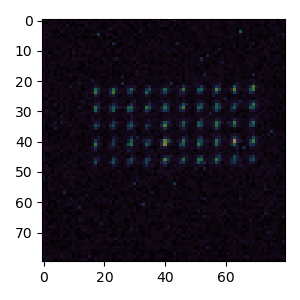

In [3]:
%matplotlib widget
data = {}
argsThresh = {}
run = 'run16'
cam = 'pvcam'

data[cam] = dataset(run + '\\' + cam, prefix)
argsThresh[cam] = np.load(prefix+'\\thresholds230609_15ms.npz')
positions, thresholds, weights, rAtom = argsThresh[cam]['positions'], argsThresh[cam]['thresholds'], argsThresh[cam]['weights'], argsThresh[cam]['rAtom']
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=True)

showImageArgs = {'positions': positions, 'rAtom': rAtom, 'imagesPerSequence': 2, 'whichImage': 0, 'binaryPics': False,
                 'circle': False, 'transpose': True, 'averaged': True, 'ROI': (0, 0, 4000, 1000), 
                 'cameraType': 'pvcam', 'plotOptions': {'vmin': 0, 'vmax': 30, 'cmap': 'cubehelix'}}
img = showPositionsExperiment(data[cam].files[-1], showImageArgs)

In [4]:
%matplotlib inline
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=False)
data[cam].addParams(run, prefix)

mParams = ['trapModulationFrequency_Hz']
includefn = lambda f: True  # if f.params['iterator'] ==52  else False
fx = 1e-3
center = 0

d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.where([1] * 50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':True}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)
x = (d.x_raw - center) * fx


res.addResult(run, mParams, x, y, yerr)
fit, cov = autoFitGaussianNeg(x, y)

plt.figure()
res.plot([run], plotOptions={'linestyle':'--', 'marker':'o'})
res.plotFittedCurve(gaussian, x, fit)
plt.title('trap freq = {:.2f} $\\pm$ {:.2f} kHz'.format(fit[1]/2, cov[1,1]**0.5/2))
plt.legend()
plt.xlabel('Modulation frequency [kHz]')
plt.gca().set_prop_cycle(None)
plt.show()


# plt.figure()
# plt.errorbar(1/x, y, yerr, linestyle='--', marker='o')
# # res.plotFittedCurve(fn, x, fit)
# # plt.legend()
# plt.xlabel('Modulation frequency [kHz]') 
# # plt.xscale('log')
# plt.gca().set_prop_cycle(None)
# plt.ylim(0,1)
# plt.show()




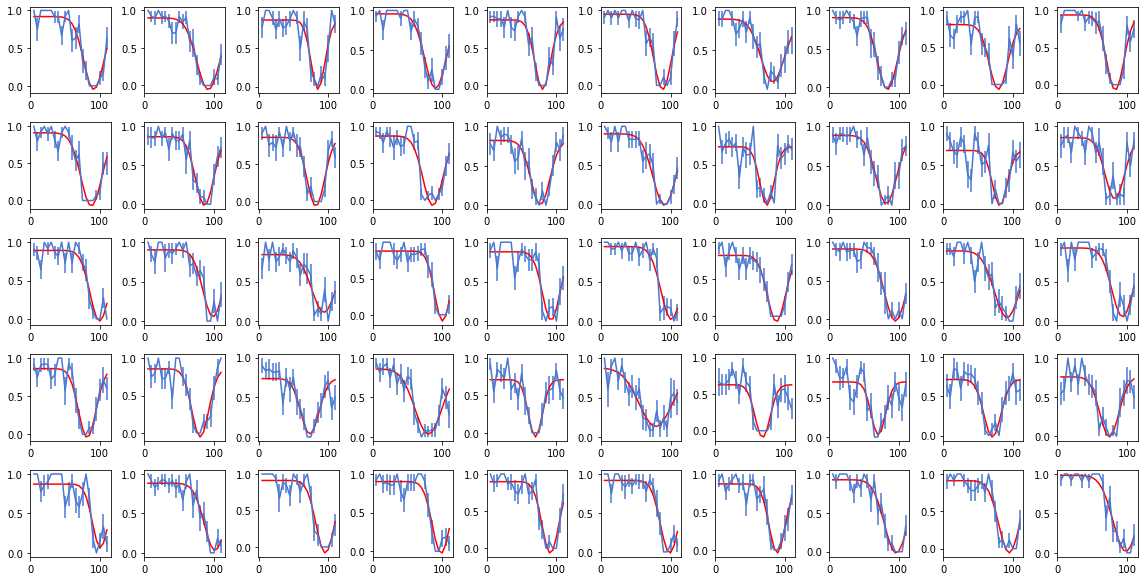

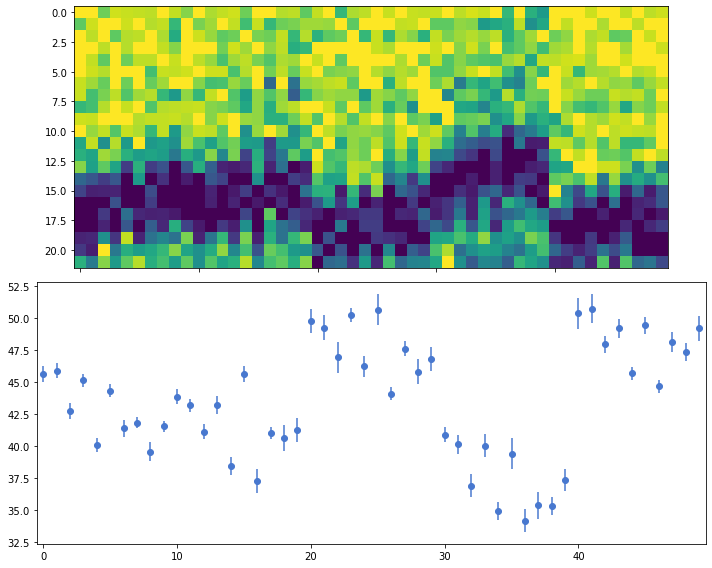

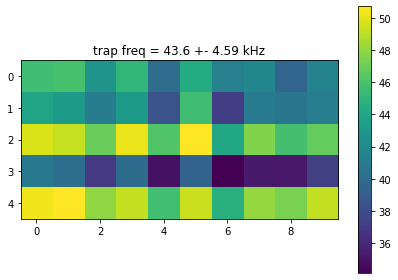

In [6]:
d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.where([1] *50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':False}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)

sites = np.arange(50)
trapFreq = []
trapFreqErr = []
R2list= []
plt.figure(figsize=(16,16))
fit = None
for i in range(50):
    
    fit,cov = autoFitGaussianNeg(x, y[:,i])
    trapFreq.append(fit[1]/2)
    trapFreqErr.append(cov[1,1]**0.5/2)
    R2 = getR2(x, y[:,i], gaussian, fit)
    R2list.append(R2)
    plt.subplot(10, 10, i+1)
    plt.errorbar(x, y[:,i], yerr[:,i])
    plt.plot(x, gaussian(x, *fit), 'r')
plt.show()

f, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(10,8), constrained_layout=True)
plt.sca(ax1)
plt.imshow(y)
xlim=plt.xlim()
plt.sca(ax2)
plt.errorbar(sites, trapFreq,yerr = trapFreqErr,marker='o',linestyle='')
plt.xlim(xlim)
plt.tight_layout()
plt.show()

plt.figure()
plt.imshow(np.reshape(trapFreq,(-1,10)))
plt.title('trap freq = {:.1f} +- {:.2f} kHz'.format(np.mean(trapFreq), np.std(trapFreq)))
plt.colorbar()
plt.show()

# Run18: pulsing trap, modulate time 100 ms, duty cycle = 50%; scan time vs modulate freq

peak voltage on scope: 564 mV; bottom:76mV

Checking and converting all pictures into binary:   0%|          | 0/37 [00:00<?, ?it/s]

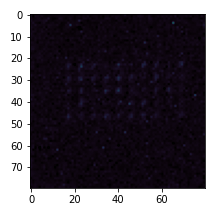

In [316]:
%matplotlib widget
data = {}
argsThresh = {}
run = 'run18'
cam = 'pvcam'

data[cam] = dataset(run + '\\' + cam, prefix)
argsThresh[cam] = np.load(prefix+'\\thresholds230602_15ms.npz')
positions, thresholds, weights, rAtom = argsThresh[cam]['positions'], argsThresh[cam]['thresholds'], argsThresh[cam]['weights'], argsThresh[cam]['rAtom']
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=True)

showImageArgs = {'positions': positions, 'rAtom': rAtom, 'imagesPerSequence': 2, 'whichImage': 0, 'binaryPics': False,
                 'circle': False, 'transpose': True, 'averaged': True, 'ROI': (0, 0, 4000, 1000), 
                 'cameraType': 'pvcam', 'plotOptions': {'vmin': 0, 'vmax': 30, 'cmap': 'cubehelix'}}
img = showPositionsExperiment(data[cam].files[-1], showImageArgs)

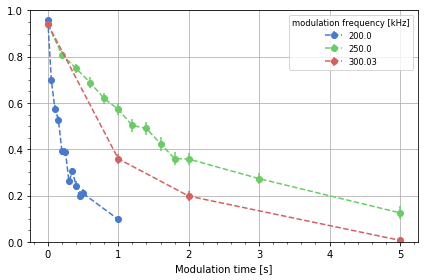

In [317]:
%matplotlib inline
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=False)
data[cam].addParams(run, prefix)

mParams = ['trapModulationTime','modulationPeriod']
includefn = lambda f: True  # if f.params['iterator'] ==52  else False
fx = 1
center = 0

d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.where([1] * 50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':True}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)
x = (d.x_raw - center) * fx
x[:,1] = np.round(1/x[:,1]*1e-3,2)

fn = lambda x,a,tau: a*np.exp(-x/tau)
# fn = lambda x, a, f, phi, c: a * np.cos(2 * np.pi * f * x - phi) + c
res.addResult(run, mParams, x, y, yerr)
# fit, errs = res.fitResult(run, 'mod lifetime @ 250 kHz', fn, x, y, yerr=np.clip(yerr, a_min=0.01, a_max=np.inf), fit_options={'p0': [0.9,1], 'maxfev': 30000})

plt.figure()
res.plot([run], plotOptions={'linestyle':'--', 'marker':'o'})
# res.plotFittedCurve(fn, x, fit)
plt.legend(title='modulation frequency [kHz]')
plt.xlabel('Modulation time [s]') 
plt.gca().set_prop_cycle(None)
plt.ylim(0,1)
plt.show()

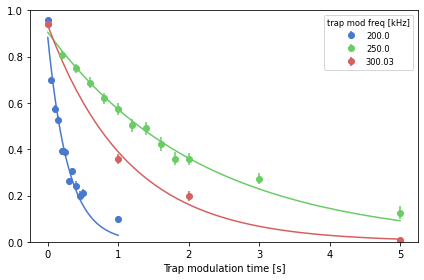

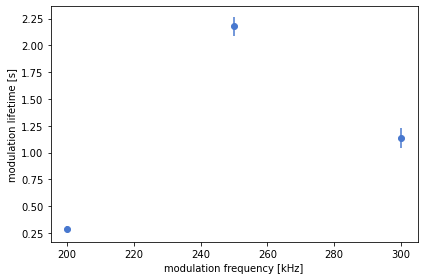

In [318]:
x2Vals = np.unique(x[:,1])
fn = lambda x,a,tau:a*np.exp(-x/tau)
fits = []
errs = []
plt.figure()
for x2 in x2Vals:
    xd,yd,yerr = res.getSingleParameterData(run, x2,includeError=True)
    fit,cov = curve_fit(fn, xd,yd,p0 = [1,1])
    xx = smooth(xd)

    line = plt.plot(xx,fn(xx,*fit))
    plt.errorbar(xd,yd,yerr,marker='o',linestyle='',color=line[0].get_color(),label=x2)

    fits.append(fit[1])
    errs.append(cov[1,1]**0.5)
    xx = smooth(xd)
plt.xlabel('Trap modulation time [s]') 
plt.legend(title='trap mod freq [kHz]')
plt.ylim(0,1)
plt.show()
plt.figure()
plt.errorbar(x2Vals, fits,yerr = errs,marker='o',linestyle='')
plt.ylabel('modulation lifetime [s]')
plt.xlabel('modulation frequency [kHz]')
plt.show()

# Run19: pulsing trap, modulate time 100 ms, duty cycle = 50%; scan time vs modulate freq; repeat 250kHz

peak voltage on scope: 564 mV; bottom:76mV

Checking and converting all pictures into binary:   0%|          | 0/35 [00:00<?, ?it/s]

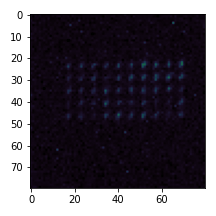

In [312]:
%matplotlib widget
data = {}
argsThresh = {}
run = 'run19'
cam = 'pvcam'

data[cam] = dataset(run + '\\' + cam, prefix)
argsThresh[cam] = np.load(prefix+'\\thresholds230602_15ms.npz')
positions, thresholds, weights, rAtom = argsThresh[cam]['positions'], argsThresh[cam]['thresholds'], argsThresh[cam]['weights'], argsThresh[cam]['rAtom']
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=True)

showImageArgs = {'positions': positions, 'rAtom': rAtom, 'imagesPerSequence': 2, 'whichImage': 0, 'binaryPics': False,
                 'circle': False, 'transpose': True, 'averaged': True, 'ROI': (0, 0, 4000, 1000), 
                 'cameraType': 'pvcam', 'plotOptions': {'vmin': 0, 'vmax': 30, 'cmap': 'cubehelix'}}
img = showPositionsExperiment(data[cam].files[-1], showImageArgs)

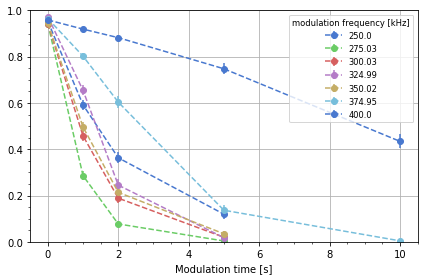

In [313]:
%matplotlib inline
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=False)
data[cam].addParams(run, prefix)

mParams = ['trapModulationTime','modulationPeriod']
includefn = lambda f: True  # if f.params['iterator'] ==52  else False
fx = 1
center = 0

d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.where([1] * 50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':True}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)
x = (d.x_raw - center) * fx
x[:,1] = np.round(1/x[:,1]*1e-3,2)

fn = lambda x,a,tau: a*np.exp(-x/tau)
# fn = lambda x, a, f, phi, c: a * np.cos(2 * np.pi * f * x - phi) + c
res.addResult(run, mParams, x, y, yerr)
# fit, errs = res.fitResult(run, 'mod lifetime @ 250 kHz', fn, x, y, yerr=np.clip(yerr, a_min=0.01, a_max=np.inf), fit_options={'p0': [0.9,1], 'maxfev': 30000})

plt.figure()
res.plot([run], plotOptions={'linestyle':'--', 'marker':'o'})
# res.plotFittedCurve(fn, x, fit)
plt.legend(title='modulation frequency [kHz]')
plt.xlabel('Modulation time [s]') 
plt.gca().set_prop_cycle(None)
plt.ylim(0,1)
plt.show()

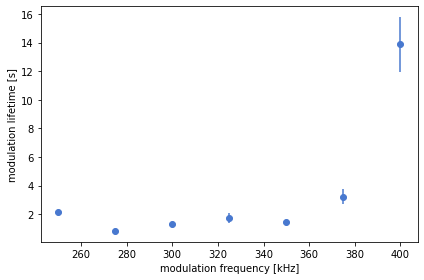

In [315]:
x2Vals = np.unique(x[:,1])
fn = lambda x,a,tau:a*np.exp(-x/tau)
fits = []
errs = []
plt.figure()
for x2 in x2Vals:
    xd,yd,yerr = res.getSingleParameterData(run, x2,includeError=True)
    fit,cov = curve_fit(fn, xd,yd,p0 = [1,1])
    xx = smooth(xd)

    line = plt.plot(xx,fn(xx,*fit))
    plt.errorbar(xd,yd,yerr,marker='o',linestyle='',color=line[0].get_color(),label=x2)

    fits.append(fit[1])
    errs.append(cov[1,1]**0.5)
    xx = smooth(xd)
plt.xlabel('Trap modulation time [s]') 
plt.legend(title='trap mod freq [kHz]')
plt.ylim(0,1)
plt.show()
plt.figure()
plt.errorbar(x2Vals, fits,yerr = errs,marker='o',linestyle='')
plt.ylabel('modulation lifetime [s]')
plt.xlabel('modulation frequency [kHz]')
plt.show()

# Run21: specRyd detuning, 0.05 waiting time, no modulation

In [52]:
%matplotlib widget
data = {}
argsThresh = {}
run = 'run21'
cam = 'pvcam'

data[cam] = dataset(run + '\\' + cam, prefix)
argsThresh[cam] = np.load(prefix+'\\thresholds230602_15ms.npz')
positions, thresholds, weights, rAtom = argsThresh[cam]['positions'], argsThresh[cam]['thresholds'], argsThresh[cam]['weights'], argsThresh[cam]['rAtom']
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=True)

showImageArgs = {'positions': positions, 'rAtom': rAtom, 'imagesPerSequence': 2, 'whichImage': 0, 'binaryPics': False,
                 'circle': False, 'transpose': True, 'averaged': True, 'ROI': (0, 0, 4000, 1000), 
                 'cameraType': 'pvcam', 'plotOptions': {'vmin': 0, 'vmax': 30, 'cmap': 'cubehelix'}}
img = showPositionsExperiment(data[cam].files[-1], showImageArgs)

Checking and converting all pictures into binary:   0%|          | 0/35 [00:00<?, ?it/s]

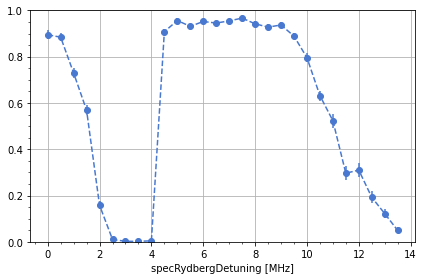

In [57]:
%matplotlib inline
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=False)
data[cam].addParams(run, prefix)

mParams = ['specRydbergDetuning_MHz']
includefn = lambda f: True  # if f.params['iterator'] ==52  else False
fx = 4
center = 0

d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.where([1] * 50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':True}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)
x = (d.x_raw - center) * fx
# x[:,1] = np.round(1/x[:,1]*1e-3,2)

fn = lambda x,a,tau: a*np.exp(-x/tau)
# fn = lambda x, a, f, phi, c: a * np.cos(2 * np.pi * f * x - phi) + c
res.addResult(run, mParams, x, y, yerr)
# fit, errs = res.fitResult(run, 'mod lifetime @ 250 kHz', fn, x, y, yerr=np.clip(yerr, a_min=0.01, a_max=np.inf), fit_options={'p0': [0.9,1], 'maxfev': 30000})

plt.figure()
res.plot([run], plotOptions={'linestyle':'--', 'marker':'o'})
# res.plotFittedCurve(fn, x, fit)
plt.xlabel('specRydbergDetuning [MHz]') 
plt.gca().set_prop_cycle(None)
plt.ylim(0,1)
plt.show()

# Run22: specRyd detuning, 0.05 modulation time, 200 kHz modulation

Checking and converting all pictures into binary:   0%|          | 0/19 [00:00<?, ?it/s]

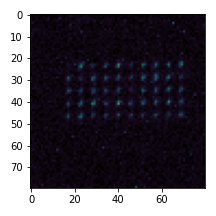

In [58]:
%matplotlib widget
data = {}
argsThresh = {}
run = 'run22'
cam = 'pvcam'

data[cam] = dataset(run + '\\' + cam, prefix)
argsThresh[cam] = np.load(prefix+'\\thresholds230602_15ms.npz')
positions, thresholds, weights, rAtom = argsThresh[cam]['positions'], argsThresh[cam]['thresholds'], argsThresh[cam]['weights'], argsThresh[cam]['rAtom']
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=True)

showImageArgs = {'positions': positions, 'rAtom': rAtom, 'imagesPerSequence': 2, 'whichImage': 0, 'binaryPics': False,
                 'circle': False, 'transpose': True, 'averaged': True, 'ROI': (0, 0, 4000, 1000), 
                 'cameraType': 'pvcam', 'plotOptions': {'vmin': 0, 'vmax': 30, 'cmap': 'cubehelix'}}
img = showPositionsExperiment(data[cam].files[-1], showImageArgs)

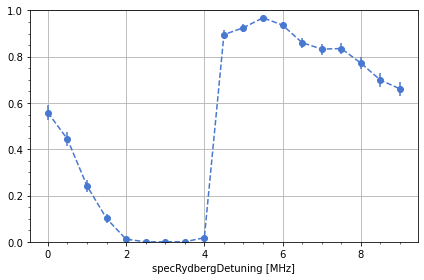

In [59]:
%matplotlib inline
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=False)
data[cam].addParams(run, prefix)

mParams = ['specRydbergDetuning_MHz']
includefn = lambda f: True  # if f.params['iterator'] ==52  else False
fx = 4
center = 0

d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.where([1] * 50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':True}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)
x = (d.x_raw - center) * fx
# x[:,1] = np.round(1/x[:,1]*1e-3,2)

fn = lambda x,a,tau: a*np.exp(-x/tau)
# fn = lambda x, a, f, phi, c: a * np.cos(2 * np.pi * f * x - phi) + c
res.addResult(run, mParams, x, y, yerr)
# fit, errs = res.fitResult(run, 'mod lifetime @ 250 kHz', fn, x, y, yerr=np.clip(yerr, a_min=0.01, a_max=np.inf), fit_options={'p0': [0.9,1], 'maxfev': 30000})

plt.figure()
res.plot([run], plotOptions={'linestyle':'--', 'marker':'o'})
# res.plotFittedCurve(fn, x, fit)
plt.xlabel('specRydbergDetuning [MHz]') 
plt.gca().set_prop_cycle(None)
plt.ylim(0,1)
plt.show()

# Run23: specRyd detuning, 0.1 modulation time, 200 kHz modulation, power = 180mW

Checking and converting all pictures into binary:   0%|          | 0/14 [00:00<?, ?it/s]

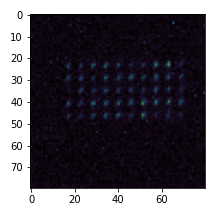

In [60]:
%matplotlib widget
data = {}
argsThresh = {}
run = 'run23'
cam = 'pvcam'

data[cam] = dataset(run + '\\' + cam, prefix)
argsThresh[cam] = np.load(prefix+'\\thresholds230602_15ms.npz')
positions, thresholds, weights, rAtom = argsThresh[cam]['positions'], argsThresh[cam]['thresholds'], argsThresh[cam]['weights'], argsThresh[cam]['rAtom']
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=True)

showImageArgs = {'positions': positions, 'rAtom': rAtom, 'imagesPerSequence': 2, 'whichImage': 0, 'binaryPics': False,
                 'circle': False, 'transpose': True, 'averaged': True, 'ROI': (0, 0, 4000, 1000), 
                 'cameraType': 'pvcam', 'plotOptions': {'vmin': 0, 'vmax': 30, 'cmap': 'cubehelix'}}
img = showPositionsExperiment(data[cam].files[-1], showImageArgs)

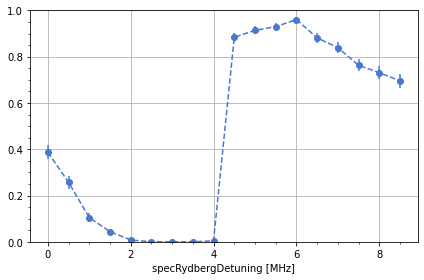

In [62]:
%matplotlib inline
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=False)
data[cam].addParams(run, prefix)

mParams = ['specRydbergDetuning_MHz']
includefn = lambda f: True  # if f.params['iterator'] ==52  else False
fx = 4
center = 0

d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.where([1] * 50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':True}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)
x = (d.x_raw - center) * fx
# x[:,1] = np.round(1/x[:,1]*1e-3,2)

fn = lambda x,a,tau: a*np.exp(-x/tau)
# fn = lambda x, a, f, phi, c: a * np.cos(2 * np.pi * f * x - phi) + c
res.addResult(run, mParams, x, y, yerr)
# fit, errs = res.fitResult(run, 'mod lifetime @ 250 kHz', fn, x, y, yerr=np.clip(yerr, a_min=0.01, a_max=np.inf), fit_options={'p0': [0.9,1], 'maxfev': 30000})

plt.figure()
res.plot([run], plotOptions={'linestyle':'--', 'marker':'o'})
# res.plotFittedCurve(fn, x, fit)
plt.xlabel('specRydbergDetuning [MHz]') 
plt.gca().set_prop_cycle(None)
plt.ylim(0,1)
plt.show()

# Run24: specRyd detuning, 0.1 modulation time, 200 kHz modulation, power = 360mW

Checking and converting all pictures into binary:   0%|          | 0/11 [00:00<?, ?it/s]

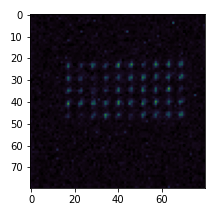

In [63]:
%matplotlib widget
data = {}
argsThresh = {}
run = 'run24'
cam = 'pvcam'

data[cam] = dataset(run + '\\' + cam, prefix)
argsThresh[cam] = np.load(prefix+'\\thresholds230602_15ms.npz')
positions, thresholds, weights, rAtom = argsThresh[cam]['positions'], argsThresh[cam]['thresholds'], argsThresh[cam]['weights'], argsThresh[cam]['rAtom']
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=True)

showImageArgs = {'positions': positions, 'rAtom': rAtom, 'imagesPerSequence': 2, 'whichImage': 0, 'binaryPics': False,
                 'circle': False, 'transpose': True, 'averaged': True, 'ROI': (0, 0, 4000, 1000), 
                 'cameraType': 'pvcam', 'plotOptions': {'vmin': 0, 'vmax': 30, 'cmap': 'cubehelix'}}
img = showPositionsExperiment(data[cam].files[-1], showImageArgs)

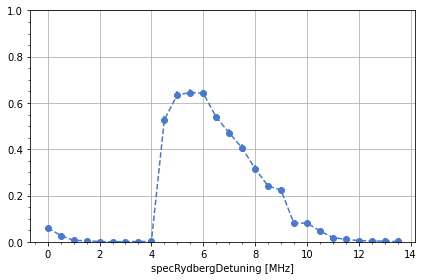

In [66]:
%matplotlib inline
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=False)
data[cam].addParams(run, prefix)

mParams = ['specRydbergDetuning_MHz']
includefn = lambda f: True  # if f.params['iterator'] ==52  else False
fx = 4
center = 0

d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.where([1] * 50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':True}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)
x = (d.x_raw - center) * fx
# x[:,1] = np.round(1/x[:,1]*1e-3,2)

fn = lambda x,a,tau: a*np.exp(-x/tau)
# fn = lambda x, a, f, phi, c: a * np.cos(2 * np.pi * f * x - phi) + c
res.addResult(run, mParams, x, y, yerr)
# fit, errs = res.fitResult(run, 'mod lifetime @ 250 kHz', fn, x, y, yerr=np.clip(yerr, a_min=0.01, a_max=np.inf), fit_options={'p0': [0.9,1], 'maxfev': 30000})

plt.figure()
res.plot([run], plotOptions={'linestyle':'--', 'marker':'o'})
# res.plotFittedCurve(fn, x, fit)
plt.xlabel('specRydbergDetuning [MHz]') 
plt.gca().set_prop_cycle(None)
plt.ylim(0,1)
plt.show()

# Run26: scan the modulation lifetime vs frequency
## add a low pass filter to the regulation PD; trap is regulated; confirm that the modulation looks ok on the fast PD

Checking and converting all pictures into binary:   0%|          | 0/101 [00:00<?, ?it/s]

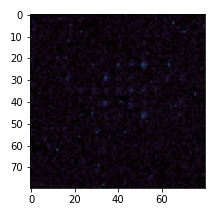

In [319]:
%matplotlib widget
data = {}
argsThresh = {}
run = 'run26'
cam = 'pvcam'

data[cam] = dataset(run + '\\' + cam, prefix)
argsThresh[cam] = np.load(prefix+'\\thresholds230602_15ms.npz')
positions, thresholds, weights, rAtom = argsThresh[cam]['positions'], argsThresh[cam]['thresholds'], argsThresh[cam]['weights'], argsThresh[cam]['rAtom']
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=True)

showImageArgs = {'positions': positions, 'rAtom': rAtom, 'imagesPerSequence': 2, 'whichImage': 0, 'binaryPics': False,
                 'circle': False, 'transpose': True, 'averaged': True, 'ROI': (0, 0, 4000, 1000), 
                 'cameraType': 'pvcam', 'plotOptions': {'vmin': 0, 'vmax': 30, 'cmap': 'cubehelix'}}
img = showPositionsExperiment(data[cam].files[-1], showImageArgs)

In [330]:
%matplotlib inline
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=False)
data[cam].addParams(run, prefix)

mParams = ['trapModulationTime','modulationPeriod']
includefn = lambda f: True if f.params['modulationPeriod'] !=3.003e-06  else False
fx = 1
center = 0

d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.where([1] * 50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':True}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)
x = (d.x_raw - center) * fx

print(np.unique(x[:,1]))
x[:,1] = np.round(1/x[:,1]*1e-3,2)

fn = lambda x,a,tau: a*np.exp(-x/tau)
# fn = lambda x, a, f, phi, c: a * np.cos(2 * np.pi * f * x - phi) + c
res.addResult(run, mParams, x, y, yerr)
# fit, errs = res.fitResult(run, 'mod lifetime @ 250 kHz', fn, x, y, yerr=np.clip(yerr, a_min=0.01, a_max=np.inf), fit_options={'p0': [0.9,1], 'maxfev': 30000})

plt.figure()
res.plot([run], plotOptions={'linestyle':'--', 'marker':'o'})
# res.plotFittedCurve(fn, x, fit)
plt.legend(title='modulation frequency [kHz]')
plt.xlabel('Modulation time [s]') 
plt.gca().set_prop_cycle(None)
# plt.ylim(0,1)
# plt.yscale('log')
plt.show()

[2.500e-06 2.591e-06 2.857e-06 3.077e-06 3.333e-06 3.636e-06 4.000e-06
 5.000e-06]


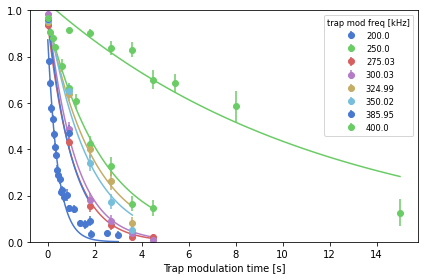

In [337]:
x2Vals = np.unique(x[:,1])
fn = lambda x,a,tau:a*np.exp(-x/tau)
fits = []
errs = []
plt.figure()
for x2 in x2Vals:
    xd,yd,yerr = res.getSingleParameterData(run, x2,includeError=True)
    fit,cov = curve_fit(fn, xd,yd,p0 = [1,1])
    xx = smooth(xd)

    line = plt.plot(xx,fn(xx,*fit))
    plt.errorbar(xd,yd,yerr,marker='o',linestyle='',color=line[0].get_color(),label=x2)

    fits.append(fit[1])
    errs.append(cov[1,1]**0.5)
    xx = smooth(xd)
plt.xlabel('Trap modulation time [s]') 
plt.legend(title='trap mod freq [kHz]')
plt.ylim(0,1)
plt.show()
plt.figure()
plt.errorbar(x2Vals[:-1], fits[:-1],yerr = errs[:-1],marker='o',linestyle='')
plt.ylabel('modulation lifetime [s]')
plt.xlabel('modulation frequency [kHz]')
# plt.yscale('log')
plt.show()

# Run27: scan the modulation frequency, modulation time = 0.5 s
## add a low pass filter to the regulation PD; trap is regulated; confirm that the modulation looks ok on the fast PD

Checking and converting all pictures into binary:   0%|          | 0/3 [00:00<?, ?it/s]

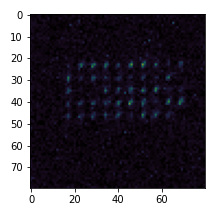

In [121]:
%matplotlib widget
data = {}
argsThresh = {}
run = 'run27'
cam = 'pvcam'

data[cam] = dataset(run + '\\' + cam, prefix)
argsThresh[cam] = np.load(prefix+'\\thresholds230602_15ms.npz')
positions, thresholds, weights, rAtom = argsThresh[cam]['positions'], argsThresh[cam]['thresholds'], argsThresh[cam]['weights'], argsThresh[cam]['rAtom']
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=True)

showImageArgs = {'positions': positions, 'rAtom': rAtom, 'imagesPerSequence': 2, 'whichImage': 0, 'binaryPics': False,
                 'circle': False, 'transpose': True, 'averaged': True, 'ROI': (0, 0, 4000, 1000), 
                 'cameraType': 'pvcam', 'plotOptions': {'vmin': 0, 'vmax': 30, 'cmap': 'cubehelix'}}
img = showPositionsExperiment(data[cam].files[-1], showImageArgs)

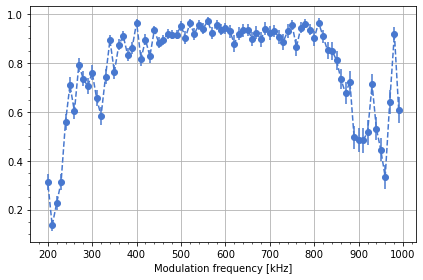

In [147]:
%matplotlib inline
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=False)
data[cam].addParams(run, prefix)

mParams = ['modulationPeriod']
includefn = lambda f: True  # if f.params['iterator'] ==52  else False
fx = 1e3
center = 0

d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.where([1] * 50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':True}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)
x = (d.x_raw - center) * fx
x=1/x
fn = lambda x,a,tau: a*np.exp(-x/tau)
# fn = lambda x, a, f, phi, c: a * np.cos(2 * np.pi * f * x - phi) + c
res.addResult(run, mParams, x, y, yerr)
# fit, errs = res.fitResult(run, 'mod lifetime @ 250 kHz', fn, x, y, yerr=np.clip(yerr, a_min=0.01, a_max=np.inf), fit_options={'p0': [0.9,1], 'maxfev': 30000})

plt.figure()
res.plot([run], plotOptions={'linestyle':'--', 'marker':'o'})
# res.plotFittedCurve(fn, x, fit)
# plt.legend(title='modulation frequency [kHz]')
plt.xlabel('Modulation frequency [kHz]') 
plt.gca().set_prop_cycle(None)
# plt.ylim(0,1)
# plt.yscale('log')
plt.show()

# Run29: scan the modulation frequency, modulation time = 0.5 s, 2 MHz tweezer spacing
## add a low pass filter to the regulation PD; trap is regulated; confirm that the modulation looks ok on the fast PD

In [338]:
%matplotlib widget
data = {}
argsThresh = {}
run = 'run29'
cam = 'pvcam'

data[cam] = dataset(run + '\\' + cam, prefix)
argsThresh[cam] = np.load(prefix+'\\thresholds230602_15ms.npz')
positions, thresholds, weights, rAtom = argsThresh[cam]['positions'], argsThresh[cam]['thresholds'], argsThresh[cam]['weights'], argsThresh[cam]['rAtom']
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=True)

showImageArgs = {'positions': positions, 'rAtom': rAtom, 'imagesPerSequence': 2, 'whichImage': 0, 'binaryPics': False,
                 'circle': False, 'transpose': True, 'averaged': True, 'ROI': (0, 0, 4000, 1000), 
                 'cameraType': 'pvcam', 'plotOptions': {'vmin': 0, 'vmax': 30, 'cmap': 'cubehelix'}}
img = showPositionsExperiment(data[cam].files[-1], showImageArgs)

Checking and converting all pictures into binary:   0%|          | 0/251 [00:00<?, ?it/s]

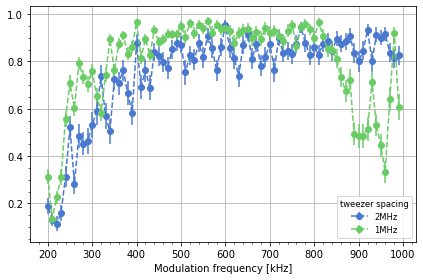

In [340]:
%matplotlib inline
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=False)
data[cam].addParams(run, prefix)

mParams = ['modulationPeriod']
includefn = lambda f: True  # if f.params['iterator'] ==52  else False
fx = 1e3
center = 0

d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.where([1] * 50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':True}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)
x = (d.x_raw - center) * fx
x=1/x
fn = lambda x,a,tau: a*np.exp(-x/tau)
# fn = lambda x, a, f, phi, c: a * np.cos(2 * np.pi * f * x - phi) + c
res.addResult(run, mParams, x, y, yerr)
# fit, errs = res.fitResult(run, 'mod lifetime @ 250 kHz', fn, x, y, yerr=np.clip(yerr, a_min=0.01, a_max=np.inf), fit_options={'p0': [0.9,1], 'maxfev': 30000})

plt.figure()
res.plot([run,'run27'], plotOptions={'linestyle':'--', 'marker':'o'})
# res.plotFittedCurve(fn, x, fit)
plt.legend(['2MHz','1MHz'],title='tweezer spacing')
plt.xlabel('Modulation frequency [kHz]') 
plt.gca().set_prop_cycle(None)
# plt.ylim(0,1)
# plt.yscale('log')
plt.show()

# Run33: scan the modulation frequency, modulation time = 0.5 s, 1 MHz spacing; heterodyne
## add a low pass filter to the regulation PD; trap is regulated; confirm that the modulation looks ok on the fast PD

Checking and converting all pictures into binary:   0%|          | 0/28 [00:00<?, ?it/s]

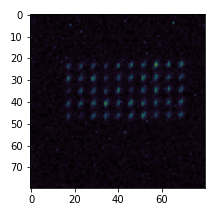

In [183]:
%matplotlib widget
data = {}
argsThresh = {}
run = 'run33'
cam = 'pvcam'

data[cam] = dataset(run + '\\' + cam, prefix)
argsThresh[cam] = np.load(prefix+'\\thresholds230609_15ms.npz')
positions, thresholds, weights, rAtom = argsThresh[cam]['positions'], argsThresh[cam]['thresholds'], argsThresh[cam]['weights'], argsThresh[cam]['rAtom']
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=True)

showImageArgs = {'positions': positions, 'rAtom': rAtom, 'imagesPerSequence': 2, 'whichImage': 0, 'binaryPics': False,
                 'circle': False, 'transpose': True, 'averaged': True, 'ROI': (0, 0, 4000, 1000), 
                 'cameraType': 'pvcam', 'plotOptions': {'vmin': 0, 'vmax': 30, 'cmap': 'cubehelix'}}
img = showPositionsExperiment(data[cam].files[-1], showImageArgs)

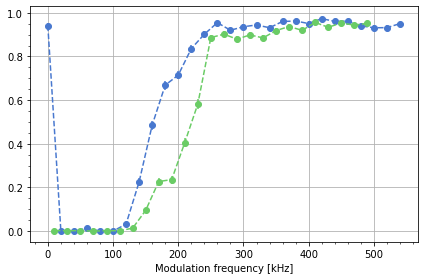

In [184]:
%matplotlib inline
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=False)
data[cam].addParams(run, prefix)

mParams = ['tweezerAOM2Frequency_MHz']
includefn = lambda f: True  # if f.params['iterator'] ==52  else False
fx = 1e3
center = 110

d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.where([1] * 50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':True}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)
x = (d.x_raw - center) * fx
fn = lambda x,a,tau: a*np.exp(-x/tau)
# fn = lambda x, a, f, phi, c: a * np.cos(2 * np.pi * f * x - phi) + c
res.addResult(run, mParams, x, y, yerr)
# fit, errs = res.fitResult(run, 'mod lifetime @ 250 kHz', fn, x, y, yerr=np.clip(yerr, a_min=0.01, a_max=np.inf), fit_options={'p0': [0.9,1], 'maxfev': 30000})

plt.figure()
res.plot([run,'run13'], plotOptions={'linestyle':'--', 'marker':'o'})
# res.plotFittedCurve(fn, x, fit)
# plt.legend(title='modulation frequency [kHz]')
plt.xlabel('Modulation frequency [kHz]') 
plt.gca().set_prop_cycle(None)
# plt.ylim(0,1)
# plt.yscale('log')
plt.show()

# Run34: dark lifetime

In [341]:
%matplotlib widget
data = {}
argsThresh = {}
run = 'run34'
cam = 'pvcam'

data[cam] = dataset(run + '\\' + cam, prefix)
argsThresh[cam] = np.load(prefix+'\\thresholds230609_15ms.npz')
positions, thresholds, weights, rAtom = argsThresh[cam]['positions'], argsThresh[cam]['thresholds'], argsThresh[cam]['weights'], argsThresh[cam]['rAtom']
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=True)

showImageArgs = {'positions': positions, 'rAtom': rAtom, 'imagesPerSequence': 2, 'whichImage': 0, 'binaryPics': False,
                 'circle': False, 'transpose': True, 'averaged': True, 'ROI': (0, 0, 4000, 1000), 
                 'cameraType': 'pvcam', 'plotOptions': {'vmin': 0, 'vmax': 30, 'cmap': 'cubehelix'}}
img = showPositionsExperiment(data[cam].files[-1], showImageArgs)

Checking and converting all pictures into binary:   0%|          | 0/16 [00:00<?, ?it/s]

In [346]:
%matplotlib inline
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=False)
data[cam].addParams(run, prefix)

mParams = ['trapModulationTime']
includefn = lambda f: True  # if f.params['iterator'] ==52  else False
fx = 1
center = 0

d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.where([1] * 50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':True}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)
x = (d.x_raw - center) * fx
# x[:,1] = np.round(1/x[:,1]*1e-3,2)

fn = lambda x,a,tau: a*np.exp(-(x/tau)**2)
# fn = lambda x, a, f, phi, c: a * np.cos(2 * np.pi * f * x - phi) + c
res.addResult(run, mParams, x, y, yerr)
fit, errs = res.fitResult(run, 'mod lifetime @ 250 kHz', fn, x, y, yerr=np.clip(yerr, a_min=0.01, a_max=np.inf), fit_options={'p0': [0.9,1], 'maxfev': 30000})

plt.figure()
res.plot([run], plotOptions={'linestyle':'', 'marker':'o'})
res.plotFittedCurve(fn, x, fit)
plt.legend(title='modulation time [s]')
plt.xlabel('Modulation time [s]') 
plt.gca().set_prop_cycle(None)
plt.ylim(0,1)
# plt.yscale('log')
plt.show()

Fit function: <lambda>
-*-*-*-*-*-*-*-*-*-*Function details*-*-*-*-*-*-*-*-*-*-
Help on function <lambda> in module __main__:

<lambda> lambda x, a, tau

-*-*-*-*-*-*-*-*-*-**-*-*-*-*-*-*-*-*-*-
|   index | Parameter name   |    Fit |   1-sigma uncertainty |
|--------:|:-----------------|-------:|----------------------:|
|       0 | a                |  0.917 |                 0.007 |
|       1 | tau              | 15.753 |                 0.761 |


# Run35: modulation with 1.5 MHz (40X trap frequency); check lifetime

Checking and converting all pictures into binary:   0%|          | 0/92 [00:00<?, ?it/s]

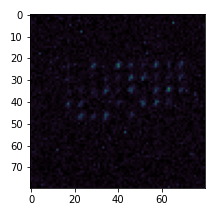

In [355]:
%matplotlib widget
data = {}
argsThresh = {}
run = 'run35'
cam = 'pvcam'

data[cam] = dataset(run + '\\' + cam, prefix)
argsThresh[cam] = np.load(prefix+'\\thresholds230609_15ms.npz')
positions, thresholds, weights, rAtom = argsThresh[cam]['positions'], argsThresh[cam]['thresholds'], argsThresh[cam]['weights'], argsThresh[cam]['rAtom']
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=True)

showImageArgs = {'positions': positions, 'rAtom': rAtom, 'imagesPerSequence': 2, 'whichImage': 0, 'binaryPics': False,
                 'circle': False, 'transpose': True, 'averaged': True, 'ROI': (0, 0, 4000, 1000), 
                 'cameraType': 'pvcam', 'plotOptions': {'vmin': 0, 'vmax': 30, 'cmap': 'cubehelix'}}
img = showPositionsExperiment(data[cam].files[-1], showImageArgs)

In [356]:
%matplotlib inline
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=False)
data[cam].addParams(run, prefix)

mParams = ['trapModulationTime','tweezerAOM2Frequency_MHz']
includefn = lambda f: True  # if f.params['iterator'] ==52  else False
fx = 1
center = 0

d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.where([1] * 50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':True}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)
x = (d.x_raw - center) * fx
# x[:,1] = np.round(1/x[:,1]*1e-3,2)

fn = lambda x,a,tau: a*np.exp(-x/tau)
# fn = lambda x, a, f, phi, c: a * np.cos(2 * np.pi * f * x - phi) + c
res.addResult(run, mParams, x, y, yerr)
# fit, errs = res.fitResult(run, 'mod lifetime @ 250 kHz', fn, x, y, yerr=np.clip(yerr, a_min=0.01, a_max=np.inf), fit_options={'p0': [0.9,1], 'maxfev': 30000})

plt.figure()
res.plot([run], plotOptions={'linestyle':'--', 'marker':'o'})
# res.plotFittedCurve(fn, x, fit)
plt.legend(title='modulation frequency [kHz]')
plt.xlabel('Modulation time [s]') 
plt.gca().set_prop_cycle(None)
# plt.ylim(0,1)
# plt.yscale('log')
plt.show()

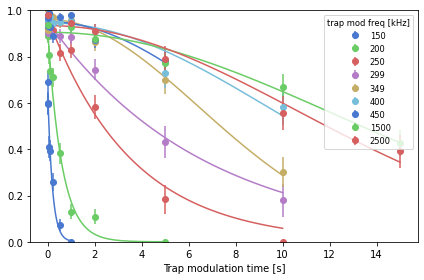

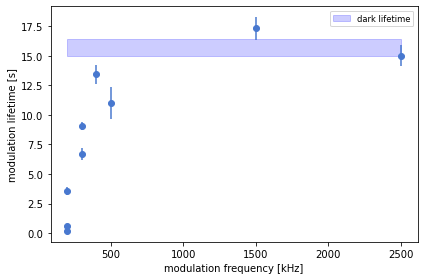

In [367]:
x2Vals = np.unique(x[:,1])
fn = lambda x,a,tau:a*np.exp(-(x/tau)**2)
fits = []
errs = []
plt.figure()
for x2 in x2Vals:
    if x2<110.35:
        fn = lambda x,a,tau:a*np.exp(-(x/tau))
    else:
        fn = lambda x,a,tau:a*np.exp(-(x/tau)**2)

    xd,yd,yerr = res.getSingleParameterData(run, x2,includeError=True)
    fit,cov = curve_fit(fn, xd,yd,p0 = [1,1])
    xx = smooth(xd)

    line = plt.plot(xx,fn(xx,*fit))
    plt.errorbar(xd,yd,yerr,marker='o',linestyle='',color=line[0].get_color(),label=int((x2-110)*1e3))

    fits.append(fit[1])
    errs.append(cov[1,1]**0.5)
    xx = smooth(xd)
plt.xlabel('Trap modulation time [s]') 
plt.legend(title='trap mod freq [kHz]')
plt.ylim(0,1)
plt.show()
plt.figure()
plt.errorbar(np.round(x2Vals-110,1)*1e3, fits,yerr = errs,marker='o',linestyle='')
plt.ylabel('modulation lifetime [s]')
plt.xlabel('modulation frequency [kHz]')
# plt.axhline(y = 15.7)
plt.fill_between(np.round(x2Vals-110,1)*1e3, 15.7 - 0.7, 15.7+0.7, color='blue', alpha=.2,label='dark lifetime')
# plt.yscale('log')
plt.legend()
plt.show()

In [366]:
np.round(x2Vals-110,0)

array([0., 0., 0., 0., 0., 0., 0., 2., 2.])

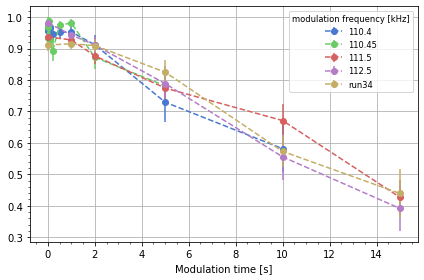

In [353]:
%matplotlib inline
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=False)
data[cam].addParams(run, prefix)

mParams = ['trapModulationTime','tweezerAOM2Frequency_MHz']
includefn = lambda f: True if f.params['tweezerAOM2Frequency_MHz'] >110.35  else False
fx = 1
center = 0

d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.where([1] * 50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':True}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)
x = (d.x_raw - center) * fx
# x[:,1] = np.round(1/x[:,1]*1e-3,2)

fn = lambda x,a,tau: a*np.exp(-x/tau)
# fn = lambda x, a, f, phi, c: a * np.cos(2 * np.pi * f * x - phi) + c
res.addResult(run, mParams, x, y, yerr)
# fit, errs = res.fitResult(run, 'mod lifetime @ 250 kHz', fn, x, y, yerr=np.clip(yerr, a_min=0.01, a_max=np.inf), fit_options={'p0': [0.9,1], 'maxfev': 30000})

plt.figure()
res.plot([run,'run34'], plotOptions={'linestyle':'--', 'marker':'o'})
# res.plotFittedCurve(fn, x, fit)
plt.legend(title='modulation frequency [kHz]')
plt.xlabel('Modulation time [s]') 
plt.gca().set_prop_cycle(None)
# plt.ylim(0,1)
# plt.yscale('log')
plt.show()

# Run36: normal exp (10ms mod and duty cycle=1)

Checking and converting all pictures into binary:   0%|          | 0/3 [00:00<?, ?it/s]

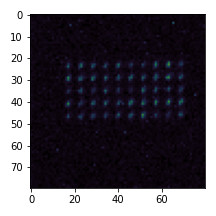

In [231]:
%matplotlib widget
data = {}
argsThresh = {}
run = 'run36'
cam = 'pvcam'

data[cam] = dataset(run + '\\' + cam, prefix)
argsThresh[cam] = np.load(prefix+'\\thresholds230609_15ms.npz')
positions, thresholds, weights, rAtom = argsThresh[cam]['positions'], argsThresh[cam]['thresholds'], argsThresh[cam]['weights'], argsThresh[cam]['rAtom']
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=True)

showImageArgs = {'positions': positions, 'rAtom': rAtom, 'imagesPerSequence': 2, 'whichImage': 0, 'binaryPics': False,
                 'circle': False, 'transpose': True, 'averaged': True, 'ROI': (0, 0, 4000, 1000), 
                 'cameraType': 'pvcam', 'plotOptions': {'vmin': 0, 'vmax': 30, 'cmap': 'cubehelix'}}
img = showPositionsExperiment(data[cam].files[-1], showImageArgs)

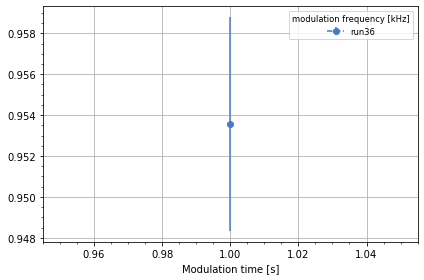

In [239]:
%matplotlib inline
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=False)
data[cam].addParams(run, prefix)

mParams = ['all']
includefn = lambda f: True  # if f.params['iterator'] ==52  else False
fx = 1
center = 0

d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.where([1] * 50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':True}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)
x = (d.x_raw - center) * fx
# x[:,1] = np.round(1/x[:,1]*1e-3,2)

fn = lambda x,a,tau: a*np.exp(-x/tau)
# fn = lambda x, a, f, phi, c: a * np.cos(2 * np.pi * f * x - phi) + c
res.addResult(run, mParams, x, y, yerr)
# fit, errs = res.fitResult(run, 'mod lifetime @ 250 kHz', fn, x, y, yerr=np.clip(yerr, a_min=0.01, a_max=np.inf), fit_options={'p0': [0.9,1], 'maxfev': 30000})

plt.figure()
res.plot([run], plotOptions={'linestyle':'--', 'marker':'o'})
# res.plotFittedCurve(fn, x, fit)
plt.legend(title='modulation frequency [kHz]')
plt.xlabel('Modulation time [s]') 
plt.gca().set_prop_cycle(None)
# plt.ylim(0,1)
# plt.yscale('log')
plt.show()
plt.figure()
experimentArgs = {'tweezerIdx': np.where([1] * 50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':False}
y2d, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs,clear=False)
plt.errorbar(np.arange(50), y2d.flatten(),yerr.flatten(),marker='o',linestyle='')
plt.show()

# Run38: ...doPA, image,image

Checking and converting all pictures into binary:   0%|          | 0/26 [00:00<?, ?it/s]

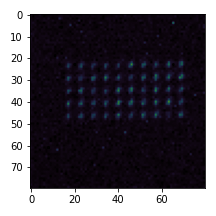

In [248]:
%matplotlib widget
data = {}
argsThresh = {}
run = 'run38'
cam = 'pvcam'

data[cam] = dataset(run + '\\' + cam, prefix)
argsThresh[cam] = np.load(prefix+'\\thresholds230609_15ms.npz')
positions, thresholds, weights, rAtom = argsThresh[cam]['positions'], argsThresh[cam]['thresholds'], argsThresh[cam]['weights'], argsThresh[cam]['rAtom']
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=True)

showImageArgs = {'positions': positions, 'rAtom': rAtom, 'imagesPerSequence': 2, 'whichImage': 0, 'binaryPics': False,
                 'circle': False, 'transpose': True, 'averaged': True, 'ROI': (0, 0, 4000, 1000), 
                 'cameraType': 'pvcam', 'plotOptions': {'vmin': 0, 'vmax': 30, 'cmap': 'cubehelix'}}
img = showPositionsExperiment(data[cam].files[-1], showImageArgs)

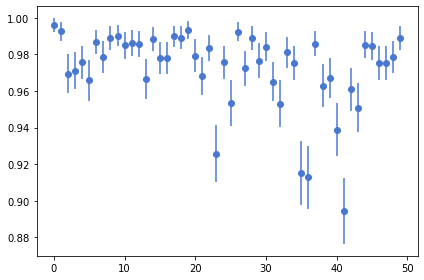

In [249]:
%matplotlib inline
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=False)
data[cam].addParams(run, prefix)

mParams = ['all']
includefn = lambda f: True  # if f.params['iterator'] ==52  else False
fx = 1
center = 0

d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.where([1] * 50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':True}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)
x = (d.x_raw - center) * fx
# x[:,1] = np.round(1/x[:,1]*1e-3,2)

fn = lambda x,a,tau: a*np.exp(-x/tau)
# fn = lambda x, a, f, phi, c: a * np.cos(2 * np.pi * f * x - phi) + c
res.addResult(run, mParams, x, y, yerr)
# fit, errs = res.fitResult(run, 'mod lifetime @ 250 kHz', fn, x, y, yerr=np.clip(yerr, a_min=0.01, a_max=np.inf), fit_options={'p0': [0.9,1], 'maxfev': 30000})

plt.figure()
res.plot([run], plotOptions={'linestyle':'--', 'marker':'o'})
# res.plotFittedCurve(fn, x, fit)
plt.legend(title='modulation frequency [kHz]')
plt.xlabel('Modulation time [s]') 
plt.gca().set_prop_cycle(None)
# plt.ylim(0,1)
# plt.yscale('log')
plt.show()
plt.figure()
experimentArgs = {'tweezerIdx': np.where([1] * 50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':False}
y2d, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs,clear=False)
plt.errorbar(np.arange(50), y2d.flatten(),yerr.flatten(),marker='o',linestyle='')
plt.show()

# We realized that Shuo used the wrong exposure time (15ms); repeat run38 again

# Run39: ...doPA, image,image

Checking and converting all pictures into binary:   0%|          | 0/15 [00:00<?, ?it/s]

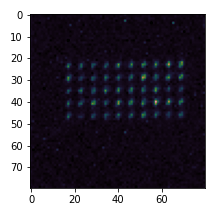

In [253]:
%matplotlib widget
data = {}
argsThresh = {}
run = 'run39'
cam = 'pvcam'

data[cam] = dataset(run + '\\' + cam, prefix)
argsThresh[cam] = np.load(prefix+'\\thresholds230609_15ms.npz')
positions, thresholds, weights, rAtom = argsThresh[cam]['positions'], argsThresh[cam]['thresholds'], argsThresh[cam]['weights'], argsThresh[cam]['rAtom']
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=True)

showImageArgs = {'positions': positions, 'rAtom': rAtom, 'imagesPerSequence': 2, 'whichImage': 0, 'binaryPics': False,
                 'circle': False, 'transpose': True, 'averaged': True, 'ROI': (0, 0, 4000, 1000), 
                 'cameraType': 'pvcam', 'plotOptions': {'vmin': 0, 'vmax': 30, 'cmap': 'cubehelix'}}
img = showPositionsExperiment(data[cam].files[-1], showImageArgs)

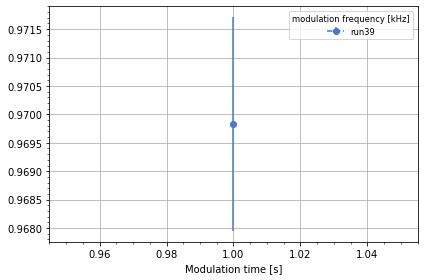

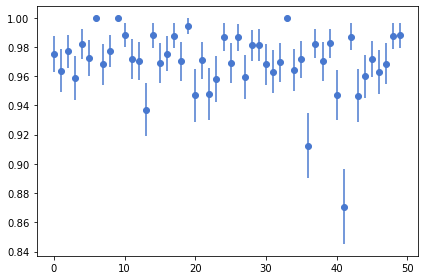

In [254]:
%matplotlib inline
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=False)
data[cam].addParams(run, prefix)

mParams = ['all']
includefn = lambda f: True  # if f.params['iterator'] ==52  else False
fx = 1
center = 0

d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.where([1] * 50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':True}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)
x = (d.x_raw - center) * fx
# x[:,1] = np.round(1/x[:,1]*1e-3,2)

fn = lambda x,a,tau: a*np.exp(-x/tau)
# fn = lambda x, a, f, phi, c: a * np.cos(2 * np.pi * f * x - phi) + c
res.addResult(run, mParams, x, y, yerr)
# fit, errs = res.fitResult(run, 'mod lifetime @ 250 kHz', fn, x, y, yerr=np.clip(yerr, a_min=0.01, a_max=np.inf), fit_options={'p0': [0.9,1], 'maxfev': 30000})

plt.figure()
res.plot([run], plotOptions={'linestyle':'--', 'marker':'o'})
# res.plotFittedCurve(fn, x, fit)
plt.legend(title='modulation frequency [kHz]')
plt.xlabel('Modulation time [s]') 
plt.gca().set_prop_cycle(None)
# plt.ylim(0,1)
# plt.yscale('log')
plt.show()
plt.figure()
experimentArgs = {'tweezerIdx': np.where([1] * 50)[0], 'imagesPerSequence': 2,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':False}
y2d, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs,clear=False)
plt.errorbar(np.arange(50), y2d.flatten(),yerr.flatten(),marker='o',linestyle='')
plt.show()

# Run40: contiuopus imaging; 100ms

Checking and converting all pictures into binary:   0%|          | 0/20 [00:00<?, ?it/s]

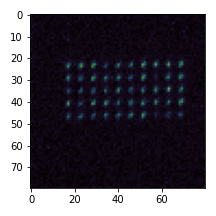

In [263]:
%matplotlib widget
data = {}
argsThresh = {}
run = 'run40'
cam = 'pvcam'

data[cam] = dataset(run + '\\' + cam, prefix)
argsThresh[cam] = np.load(prefix+'\\thresholds230609_15ms.npz')
positions, thresholds, weights, rAtom = argsThresh[cam]['positions'], argsThresh[cam]['thresholds'], argsThresh[cam]['weights'], argsThresh[cam]['rAtom']
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=True)

showImageArgs = {'positions': positions, 'rAtom': rAtom, 'imagesPerSequence': 5, 'whichImage': 0, 'binaryPics': False,
                 'circle': False, 'transpose': True, 'averaged': True, 'ROI': (0, 0, 4000, 1000), 
                 'cameraType': 'pvcam', 'plotOptions': {'vmin': 0, 'vmax': 30, 'cmap': 'cubehelix'}}
img = showPositionsExperiment(data[cam].files[-1], showImageArgs)

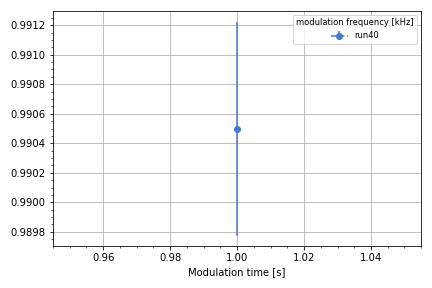

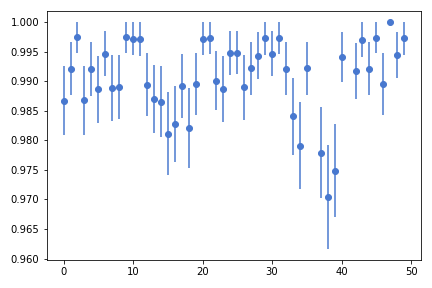

In [273]:
%matplotlib widget
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=False)
data[cam].addParams(run, prefix)

mParams = ['all']
includefn = lambda f: True  # if f.params['iterator'] ==52  else False
fx = 1
center = 0

d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.delete(np.where([1] * 50)[0],[36,41]), 'imagesPerSequence': 4,
                    'conditionedImage': 1, 'measuredImage': 2, 'pattern': [1], 'averageOverPositions':True}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)
x = (d.x_raw - center) * fx
# x[:,1] = np.round(1/x[:,1]*1e-3,2)

fn = lambda x,a,tau: a*np.exp(-x/tau)
# fn = lambda x, a, f, phi, c: a * np.cos(2 * np.pi * f * x - phi) + c
res.addResult(run, mParams, x, y, yerr)
# fit, errs = res.fitResult(run, 'mod lifetime @ 250 kHz', fn, x, y, yerr=np.clip(yerr, a_min=0.01, a_max=np.inf), fit_options={'p0': [0.9,1], 'maxfev': 30000})

plt.figure()
res.plot([run], plotOptions={'linestyle':'--', 'marker':'o'})
# res.plotFittedCurve(fn, x, fit)
plt.legend(title='modulation frequency [kHz]')
plt.xlabel('Modulation time [s]') 
plt.gca().set_prop_cycle(None)
# plt.ylim(0,1)
# plt.yscale('log')
plt.show()
plt.figure()
idx = np.delete(np.where([1] * 50)[0],[36,41])
experimentArgs = {'tweezerIdx': idx, 'imagesPerSequence': 4,
                    'conditionedImage': 1, 'measuredImage': 2, 'pattern': [1], 'averageOverPositions':False}
y2d, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs,clear=False)
plt.errorbar(idx, y2d.flatten(),yerr.flatten(),marker='o',linestyle='')
plt.show()

In [277]:
np.tile([1],4)

array([1, 1, 1, 1])

# Run41: now we want to use the science sequence to reproduce this 99% survival with 4 images

Checking and converting all pictures into binary:   0%|          | 0/4 [00:00<?, ?it/s]

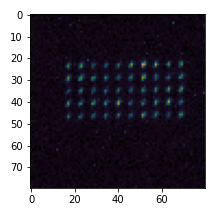

In [281]:
%matplotlib widget
data = {}
argsThresh = {}
run = 'run42'
cam = 'pvcam'

data[cam] = dataset(run + '\\' + cam, prefix)
argsThresh[cam] = np.load(prefix+'\\thresholds230609_15ms.npz')
positions, thresholds, weights, rAtom = argsThresh[cam]['positions'], argsThresh[cam]['thresholds'], argsThresh[cam]['weights'], argsThresh[cam]['rAtom']
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=True)

showImageArgs = {'positions': positions, 'rAtom': rAtom, 'imagesPerSequence': 4, 'whichImage': 0, 'binaryPics': False,
                 'circle': False, 'transpose': True, 'averaged': True, 'ROI': (0, 0, 4000, 1000), 
                 'cameraType': 'pvcam', 'plotOptions': {'vmin': 0, 'vmax': 30, 'cmap': 'cubehelix'}}
img = showPositionsExperiment(data[cam].files[-1], showImageArgs)

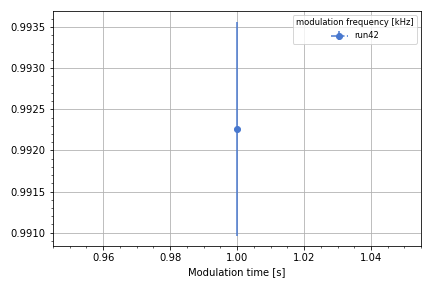

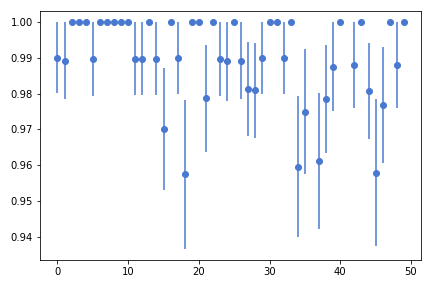

In [286]:
%matplotlib widget
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=False)
data[cam].addParams(run, prefix)

mParams = ['all']
includefn = lambda f: True  # if f.params['iterator'] ==52  else False
fx = 1
center = 0

d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.delete(np.where([1] * 50)[0],[36,41]), 'imagesPerSequence': 4,
                    'conditionedImage': 2, 'measuredImage': 3, 'pattern': [1], 'averageOverPositions':True}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)
x = (d.x_raw - center) * fx
# x[:,1] = np.round(1/x[:,1]*1e-3,2)

fn = lambda x,a,tau: a*np.exp(-x/tau)
# fn = lambda x, a, f, phi, c: a * np.cos(2 * np.pi * f * x - phi) + c
res.addResult(run, mParams, x, y, yerr)
# fit, errs = res.fitResult(run, 'mod lifetime @ 250 kHz', fn, x, y, yerr=np.clip(yerr, a_min=0.01, a_max=np.inf), fit_options={'p0': [0.9,1], 'maxfev': 30000})

plt.figure()
res.plot([run], plotOptions={'linestyle':'--', 'marker':'o'})
# res.plotFittedCurve(fn, x, fit)
plt.legend(title='modulation frequency [kHz]')
plt.xlabel('Modulation time [s]') 
plt.gca().set_prop_cycle(None)
# plt.ylim(0,1)
# plt.yscale('log')
plt.show()
plt.figure()
idx = np.delete(np.where([1] * 50)[0],[36,41])
experimentArgs = {'tweezerIdx': idx, 'imagesPerSequence': 4,
                    'conditionedImage': 1, 'measuredImage': 2, 'pattern': [1], 'averageOverPositions':False}
y2d, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs,clear=False)
plt.errorbar(idx, y2d.flatten(),yerr.flatten(),marker='o',linestyle='')
plt.show()

# Run44: now we want to use the science sequence to reproduce this 99% survival with 4 images
## We think PA is not working properly so we make PA same parameter as imaging beam (except power is higher)

Checking and converting all pictures into binary:   0%|          | 0/3 [00:00<?, ?it/s]

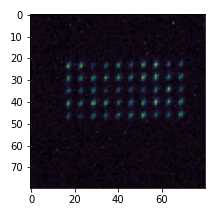

In [287]:
%matplotlib widget
data = {}
argsThresh = {}
run = 'run44'
cam = 'pvcam'

data[cam] = dataset(run + '\\' + cam, prefix)
argsThresh[cam] = np.load(prefix+'\\thresholds230609_15ms.npz')
positions, thresholds, weights, rAtom = argsThresh[cam]['positions'], argsThresh[cam]['thresholds'], argsThresh[cam]['weights'], argsThresh[cam]['rAtom']
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=True)

showImageArgs = {'positions': positions, 'rAtom': rAtom, 'imagesPerSequence': 4, 'whichImage': 0, 'binaryPics': False,
                 'circle': False, 'transpose': True, 'averaged': True, 'ROI': (0, 0, 4000, 1000), 
                 'cameraType': 'pvcam', 'plotOptions': {'vmin': 0, 'vmax': 30, 'cmap': 'cubehelix'}}
img = showPositionsExperiment(data[cam].files[-1], showImageArgs)

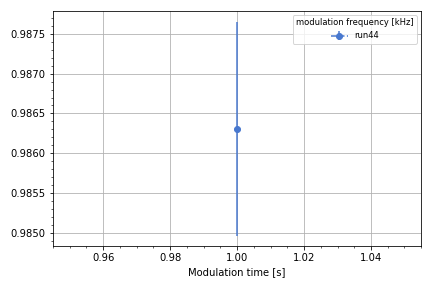

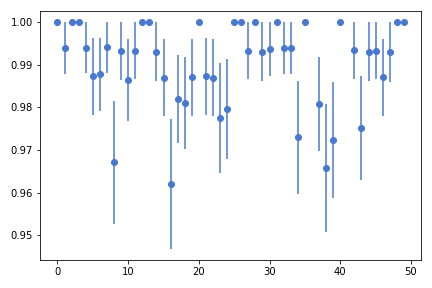

In [293]:
%matplotlib widget
data[cam].addDir(run + '\\' + cam, prefix)
data[cam].saveBinaryPics(argsThresh[cam], run + '\\' + cam, prefix, convert_all=False)
data[cam].addParams(run, prefix)

mParams = ['all']
includefn = lambda f: True  # if f.params['iterator'] ==52  else False
fx = 1
center = 0

d = measurement(data[cam], mParams, includefn=includefn)
experimentArgs = {'tweezerIdx': np.delete(np.where([1] * 50)[0],[36,41]), 'imagesPerSequence': 4,
                    'conditionedImage': 0, 'measuredImage': 1, 'pattern': [1], 'averageOverPositions':True}
y, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs)
x = (d.x_raw - center) * fx
# x[:,1] = np.round(1/x[:,1]*1e-3,2)

fn = lambda x,a,tau: a*np.exp(-x/tau)
# fn = lambda x, a, f, phi, c: a * np.cos(2 * np.pi * f * x - phi) + c
res.addResult(run, mParams, x, y, yerr)
# fit, errs = res.fitResult(run, 'mod lifetime @ 250 kHz', fn, x, y, yerr=np.clip(yerr, a_min=0.01, a_max=np.inf), fit_options={'p0': [0.9,1], 'maxfev': 30000})

plt.figure()
res.plot([run], plotOptions={'linestyle':'--', 'marker':'o'})
# res.plotFittedCurve(fn, x, fit)
plt.legend(title='modulation frequency [kHz]')
plt.xlabel('Modulation time [s]') 
plt.gca().set_prop_cycle(None)
# plt.ylim(0,1)
# plt.yscale('log')
plt.show()
plt.figure()
idx = np.delete(np.where([1] * 50)[0],[36,41])
experimentArgs = {'tweezerIdx': idx, 'imagesPerSequence': 4,
                    'conditionedImage': 1, 'measuredImage': 2, 'pattern': [1], 'averageOverPositions':False}
y2d, yerr = d.measure(survivalProbability_binary, fn_args=experimentArgs,clear=False)
plt.errorbar(idx, y2d.flatten(),yerr.flatten(),marker='o',linestyle='')
plt.show()